In [1]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib, collections, datetime, hashlib, os, re, time, sys
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 对DOT进行分析,扫描时间2021-12-21

# 合并所有文件

In [21]:
tls_raw = pd.read_json("./tls-cert-ct-revoke-scsv/ip-domain/result_tls.txt",lines=True)
cert_raw = pd.read_json("./tls-cert-ct-revoke-scsv/ip-domain/result_cert.txt",lines=True)
ct_raw = pd.read_json("./tls-cert-ct-revoke-scsv/ip-domain/result_ct.txt",lines=True)
revoke_raw = pd.read_json("./tls-cert-ct-revoke-scsv/ip-domain/result_revoke.txt",lines=True)
tlsa_caa_raw = pd.read_json("./tlsa-caa/result_tlsa_caa.txt",lines=True)
caa_analysis_raw = pd.read_csv("./tlsa-caa/caa_analysis.txt")
dane_raw = pd.read_csv("./dane/result_dane_valid.txt")
tls13_down = pd.read_json("./TLS13/down/result_down.txt",lines=True)

all_raw = pd.merge(tls_raw,cert_raw)
all_raw = pd.merge(all_raw,ct_raw)
all_raw = pd.merge(all_raw,revoke_raw)
all_raw = pd.merge(all_raw,tlsa_caa_raw,how = "outer")
all_raw = pd.merge(all_raw,caa_analysis_raw,how = "outer")
all_raw = pd.merge(all_raw,dane_raw,how = "outer")
all_raw = pd.merge(all_raw,tls13_down,how = "outer")
all_raw

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,caa_dnssec,tlsa_error,caa_error,caa_result,dnssec,dane,err,tls13_down_12,tls13_down_11,tls13_down_10
0,1dot1dot1dot1.cloudflare-dns.com,1.0.0.1,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,,,,NaN,NaN,NaN,NaN,True,False,False
1,dns3.dnsfilter.com,147.75.94.119,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZaak...,DV,True,[Let's Encrypt],True,...,,,,NaN,NaN,NaN,NaN,True,True,True
2,cloudflare-dns.com,162.159.36.16,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,,,,NaN,NaN,NaN,NaN,False,False,False
3,cloudflare-dns.com,162.159.46.26,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,,,,NaN,NaN,NaN,NaN,False,False,False
4,cloudflare-dns.com,172.64.36.38,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,,,,NaN,NaN,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11699,dns2.nextdns.io,45.90.30.28,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVLVE...,DV,True,[ZeroSSL],True,...,,,,NaN,NaN,NaN,NaN,True,False,False
11700,dns.nextdns.io,45.90.31.49,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVJek...,DV,True,[ZeroSSL],True,...,,,,NaN,NaN,NaN,NaN,True,False,False
11701,dns64.dns.google,72.43.221.35,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUY0VE...,DV,True,[Google Trust Services LLC],True,...,,,,NaN,NaN,NaN,NaN,False,False,False
11702,dns.smyck.org,84.200.79.198,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdVVE...,DV,False,[Let's Encrypt],False,...,,,,NaN,NaN,NaN,NaN,True,False,False


In [22]:
location_raw = pd.read_json("../../map/dot-location-ip.txt",lines=True)
# location_raw = pd.DataFrame(location_raw,columns = ['query','country','isp','org'])
location_raw = location_raw.rename(columns={"query":"ip"})
location_raw

,status,country,countryCode,region,regionName,city,zip,lat,lon,timezone,isp,org,as,ip
0,success,Hong Kong,HK,HCW,Central and Western District,Central,96521,22.2908,114.1501,Asia/Hong_Kong,Hong Kong Broadband Network Ltd,Hong Kong Broadband Network Ltd,AS10103 HK Broadband Network Ltd.,165.84.169.145
1,success,Taiwan,TW,KHH,Kaohsiung,Kaohsiung City,,22.6148,120.3139,Asia/Taipei,"Chunghwa Telecom Co., Ltd.",Chunghwa Telecom Co. Ltd.,AS3462 Data Communication Business Group,61.216.59.194
2,success,Canada,CA,QC,Quebec,Montreal,H4X,45.5017,-73.5673,America/Toronto,"Cloudflare, Inc.","Cloudflare, Inc.","AS13335 Cloudflare, Inc.",162.159.46.1
3,success,Canada,CA,QC,Quebec,Montreal,H4X,45.5017,-73.5673,America/Toronto,"Cloudflare, Inc.","Cloudflare, Inc.","AS13335 Cloudflare, Inc.",172.64.36.164
4,success,Canada,CA,QC,Quebec,Montreal,H4X,45.5017,-73.5673,America/Toronto,"Cloudflare, Inc.","Cloudflare, Inc.","AS13335 Cloudflare, Inc.",162.159.36.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18179,success,Canada,CA,ON,Ontario,Toronto,M5K,43.6447,-79.3840,America/Toronto,"NetActuate, Inc","Host Virtual, Inc","AS36236 NetActuate, Inc",162.248.220.187
18180,success,Russia,RU,MOW,Moscow,Moscow,101194,55.7129,37.6212,Europe/Moscow,Ionica LLC,,"AS199274 Serveroid, LLC",91.239.27.199
18181,success,Japan,JP,13,Tokyo,Tokyo,151-0053,35.6893,139.6899,Asia/Tokyo,"Linode, LLC",Linode,"AS63949 Linode, LLC",172.104.118.6
18182,success,United States,US,IA,Iowa,Radcliffe,50230,42.3249,-93.4192,America/Chicago,Aureon Network Services,Radcliffe Telephone,AS5056 Aureon Network Services,207.177.125.53


In [23]:
all_raw = pd.merge(all_raw,location_raw,how = "left",on=['ip'])
all_raw

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,region,regionName,city,zip,lat,lon,timezone,isp,org,as
0,1dot1dot1dot1.cloudflare-dns.com,1.0.0.1,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,QLD,Queensland,South Brisbane,4101,-27.4766,153.01660,Australia/Brisbane,"Cloudflare, Inc",APNIC and Cloudflare DNS Resolver project,"AS13335 Cloudflare, Inc."
1,dns3.dnsfilter.com,147.75.94.119,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZaak...,DV,True,[Let's Encrypt],True,...,NJ,New Jersey,Parsippany,07054,40.8617,-74.41040,America/New_York,"Packet Host, Inc.","Packet Host, Inc","AS54825 Packet Host, Inc."
2,cloudflare-dns.com,162.159.36.16,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,QC,Quebec,Montreal,H4X,45.5017,-73.56730,America/Toronto,"Cloudflare, Inc.","Cloudflare, Inc.","AS13335 Cloudflare, Inc."
3,cloudflare-dns.com,162.159.46.26,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,QC,Quebec,Montreal,H4X,45.5017,-73.56730,America/Toronto,"Cloudflare, Inc.","Cloudflare, Inc.","AS13335 Cloudflare, Inc."
4,cloudflare-dns.com,172.64.36.38,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,QC,Quebec,Montreal,H4X,45.5017,-73.56730,America/Toronto,"Cloudflare, Inc.","Cloudflare, Inc.","AS13335 Cloudflare, Inc."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11699,dns2.nextdns.io,45.90.30.28,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVLVE...,DV,True,[ZeroSSL],True,...,CA,California,Sunnyvale,94087,37.3481,-122.01900,America/Los_Angeles,"nextdns, Inc.","nextdns, Inc","AS34939 nextdns, Inc."
11700,dns.nextdns.io,45.90.31.49,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVJek...,DV,True,[ZeroSSL],True,...,DE,Delaware,Wilmington,19802,39.7528,-75.52990,America/New_York,"nextdns, Inc.","nextdns, Inc","AS34939 nextdns, Inc."
11701,dns64.dns.google,72.43.221.35,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUY0VE...,DV,True,[Google Trust Services LLC],True,...,NY,New York,Newark,14513,43.0475,-77.09400,America/New_York,Spectrum,V TECHNICAL TEXTILES INC,AS11351 Charter Communications Inc
11702,dns.smyck.org,84.200.79.198,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdVVE...,DV,False,[Let's Encrypt],False,...,HE,Hesse,Frankfurt am Main,60388,50.1396,8.74294,Europe/Berlin,diva-e Datacenters GmbH,IP- Accelerated IT Services GmbH,AS31400 diva-e Datacenters GmbH


In [10]:

all_raw["tlsVersion"].value_counts()/len(all_raw)

TLSv1.3    0.841080
TLSv1.2    0.114405
           0.044515
Name: tlsVersion, dtype: float64

In [8]:
all_raw[all_raw["tlsVersion"]=="TLSv1.3"].domain.value_counts()
all_raw[all_raw["tlsVersion"]=="TLSv1.3"].domain.value_counts()/len(all_raw)*100

dns.nextdns.io           2492
com.apple.dnssd-proxy    1284
cloudflare-dns.com       1043
dal-1.edge.nextdns.io     255
ams-1.edge.nextdns.io     255
                         ... 
dns2.edunote.cn             1
nyc20110.eerodns.com        1
dns.plausant.com            1
dns.colorfreedom.org        1
dns.smyck.org               1
Name: domain, Length: 1524, dtype: int64

dns.nextdns.io           21.291866
com.apple.dnssd-proxy    10.970608
cloudflare-dns.com        8.911483
dal-1.edge.nextdns.io     2.178742
ams-1.edge.nextdns.io     2.178742
                           ...    
dns2.edunote.cn           0.008544
nyc20110.eerodns.com      0.008544
dns.plausant.com          0.008544
dns.colorfreedom.org      0.008544
dns.smyck.org             0.008544
Name: domain, Length: 1524, dtype: float64

In [9]:
all_raw[all_raw["tlsVersion"]=="TLSv1.3"].raw_cert_chain.value_counts()

LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVJekNDQTZxZ0F3SUJBZ0lRRGdHbW85UVVQOHBxOStwN1Y3WHY3VEFLQmdncWhrak9QUVFEQXpCTE1Rc3cKQ1FZRFZRUUdFd0pCVkRFUU1BNEdBMVVFQ2hNSFdtVnliMU5UVERFcU1DZ0dBMVVFQXhNaFdtVnliMU5UVENCRgpRME1nUkc5dFlXbHVJRk5sWTNWeVpTQlRhWFJsSUVOQk1CNFhEVEl4TVRBeU5qQXdNREF3TUZvWERUSXlNREV5Ck5ESXpOVGsxT1Zvd0dURVhNQlVHQTFVRUF4TU9aRzV6TG01bGVIUmtibk11YVc4d1dUQVRCZ2NxaGtqT1BRSUIKQmdncWhrak9QUU1CQndOQ0FBUkdTaUxDUVlGZFZMeWplNkNPMVZEeXBLNEpyV3k5d3QyN20vRGtKb3JEZm9tcQpLRUZVaXNmTzJIL1pEaHZxM1F5NjBma3hBem8rRkk4SmRtd20zaTdpbzRJQ29EQ0NBcHd3SHdZRFZSMGpCQmd3CkZvQVVEMnZtUzg0NVI2NzJmcEFlZWZBd2taTElYNk13SFFZRFZSME9CQllFRkVEeDBnOVhkS3FkOTRvTHVZZG0KSGtqQVlwakxNQTRHQTFVZER3RUIvd1FFQXdJSGdEQU1CZ05WSFJNQkFmOEVBakFBTUIwR0ExVWRKUVFXTUJRRwpDQ3NHQVFVRkJ3TUJCZ2dyQmdFRkJRY0RBakJKQmdOVkhTQUVRakJBTURRR0N5c0dBUVFCc2pFQkFnSk9NQ1V3Ckl3WUlLd1lCQlFVSEFnRVdGMmgwZEhCek9pOHZjMlZqZEdsbmJ5NWpiMjB2UTFCVE1BZ0dCbWVCREFFQ0FUQ0IKaUFZSUt3WUJCUVVIQVFFRWZEQjZNRXNHQ0NzR0FRVUZCekFDaGo5b2RIUndPaTh2ZW1WeWIzTnpiQzVqY25RdQpjMlZqZEds

In [34]:
# all_raw.drop_duplicates(subset=['ip'], keep='first', inplace=True)
# all_raw

In [11]:
all_raw.drop_duplicates(subset=['domain'], keep='first', inplace=True)
all_raw

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,caa_result,dnssec,dane,err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org
0,1dot1dot1dot1.cloudflare-dns.com,1.0.0.1,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,NaN,NaN,NaN,NaN,True,False,False,Australia,"Cloudflare, Inc",APNIC and Cloudflare DNS Resolver project
1,dns3.dnsfilter.com,147.75.94.119,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZaak...,DV,True,[Let's Encrypt],True,...,NaN,NaN,NaN,NaN,True,True,True,United States,"Packet Host, Inc.","Packet Host, Inc"
2,cloudflare-dns.com,162.159.36.16,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,NaN,NaN,NaN,NaN,False,False,False,Canada,"Cloudflare, Inc.","Cloudflare, Inc."
5,com.apple.dnssd-proxy,175.119.23.36,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUNzVE...,UnknownValidationLevel,False,[Apple Inc.],True,...,NaN,NaN,NaN,NaN,False,False,False,South Korea,SK Broadband Co Ltd,SK Broadband Co Ltd
6,freedns.controld.dev,176.125.239.4,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdoVE...,DV,True,[Let's Encrypt],True,...,NaN,NaN,NaN,NaN,True,False,False,Canada,Windscribe,Zenu Software LLC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11653,lax40502.dnsfilter.co,136.144.60.207,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZaak...,DV,False,[Let's Encrypt],True,...,NaN,NaN,NaN,NaN,True,True,True,United States,"Packet Host, Inc.","Equinix Services, Inc"
11673,dns.fadaige.xyz,101.132.168.152,,False,dial tcp 101.132.168.152:853: connect: no rout...,,,False,None,False,...,NaN,NaN,NaN,NaN,False,False,False,China,Hangzhou Alibaba Advertising Co,"Aliyun Computing Co., LTD"
11679,dns-edge-asia-seoul.cleanbrowsing.org,158.247.196.17,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"[GoDaddy.com, Inc.]",True,...,NaN,NaN,NaN,NaN,False,False,False,South Korea,"The Constant Company, LLC","Choopa, LLC"
11683,176-103-130-131.dns.adguard.com,176.103.130.131,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUUwak...,DV,False,[ZeroSSL],True,...,NaN,NaN,NaN,NaN,False,False,False,Russia,"Serveroid, LLC",Ionica LLC


In [12]:
all_raw.keys()

Index(['domain', 'ip', 'tlsVersion', 'scsv', 'connError', 'raw_cert_chain',
       'cert_level', 'certValid', 'caName', 'time_valid', 'cert_lifetime',
       'cert_error', 'tlsHave', 'sct_tls_valid', 'tls_log', 'certHave',
       'cert_valid', 'cert_log', 'ocspHave', 'ocsp_valid', 'ocsp_log',
       'flagValid', 'crLs', 'crl_server', 'ocsp', 'ocspServer', 'ocspStapling',
       'ocspMustStaple', 'respect_ms', 'response_flag', 'crl_cert_status',
       'crl_response_sig', 'ocsp_cert_status', 'ocsp_response_sig',
       'ocsp_stapling_cert_status', 'ocsp_stapling_response_sig', 'tlsa',
       'caa', 'tlsa_dnssec', 'caa_dnssec', 'tlsa_error', 'caa_error',
       'caa_result', 'dnssec', 'dane', 'err', 'tls13_down_12', 'tls13_down_11',
       'tls13_down_10', 'country', 'isp', 'org'],
      dtype='object')

In [25]:
all_raw["tlsa_flag"] = all_raw.apply(lambda x: True if x.tlsa!="" else False, axis=1)
all_raw["caa_flag"] = all_raw.apply(lambda x: True if x.caa!="" else False, axis=1)

In [26]:
all_raw = all_raw.rename(columns={"err":"dane_err"})
# all_raw = all_raw.drop(columns=['raw_cert_chain','tlsa','caa','tlsa_error','caa_error'])
all_raw = all_raw.drop(columns=['tlsa','caa','tlsa_error','caa_error'])

In [27]:
all_raw = all_raw.fillna("none")

## 去除域名不匹配的DOT 

In [28]:
all_raw = all_raw.drop(all_raw[all_raw['cert_error'].str.contains("certificate is valid for")].index)
all_raw = all_raw.drop(all_raw[all_raw['cert_error'].str.contains("certificate is not valid for")].index)

In [29]:
all_raw = all_raw[(all_raw["domain"].str.contains("dns"))|(all_raw["domain"].str.contains("doh"))]

In [30]:
all_num = len(all_raw)

# 对TLS进行分析 

## 对错误连接进行分析 

In [13]:
print(all_raw["connError"].value_counts())
print("------------------------------------------------------")
print(all_raw["connError"].value_counts()/all_num)
err = all_raw[all_raw["connError"] != ""]
print("------------------------------------------------------")
print("在{}个DOT解析器中，有{}个连接错误，占比{:.2%}".format(all_num,len(err),len(err)/all_num))

                                                             1801
EOF                                                            11
dial tcp 130.225.244.166:853: connect: connection refused       4
dial tcp 151.40.63.139:853: i/o timeout                         4
dial tcp 91.13.143.227:853: i/o timeout                         3
                                                             ... 
dial tcp 199.102.78.163:853: connect: connection refused        1
dial tcp 71.202.43.152:853: i/o timeout                         1
dial tcp 192.248.180.124:853: i/o timeout                       1
dial tcp 45.253.131.94:853: connect: connection refused         1
dial tcp 101.132.168.152:853: connect: no route to host         1
Name: connError, Length: 118, dtype: int64
------------------------------------------------------
                                                             0.926917
EOF                                                          0.005661
dial tcp 130.225.244.166:853: connec

## 对TLS版本进行分析 

In [14]:
all_raw["tlsVersion"].value_counts()

TLSv1.3    1089
TLSv1.2     712
            142
Name: tlsVersion, dtype: int64

In [15]:
tls1_3 = all_raw[all_raw["tlsVersion"]=="TLSv1.3"]
tls1_2 = all_raw[all_raw["tlsVersion"]=="TLSv1.2"]
print("在{}个DOT解析器中，有{}个使用TLS1.2进行连接，占比{:.2%}".format(all_num,len(tls1_2),len(tls1_2)/all_num))
print("在{}个DOT解析器中，有{}个使用TLS1.3进行连接，占比{:.2%}".format(all_num,len(tls1_3),len(tls1_3)/all_num))

在1943个DOT解析器中，有712个使用TLS1.2进行连接，占比36.64%
在1943个DOT解析器中，有1089个使用TLS1.3进行连接，占比56.05%


## 对org和ISP进行分析 

In [16]:
print("TLS 1.3")
print("org:")
for index,value in tls1_3["org"].value_counts().iteritems():
    if value >=20:
        print(index,value,"---",value/len(tls1_3)*100) 
print("---------————————————————————————")
print("ISP:")
for index,value in tls1_3["isp"].value_counts().iteritems():
    if value >=20:
        print(index,value,"---",value/len(tls1_3)*100) 

TLS 1.3
org:
 87 --- 7.988980716253444
Hetzner 65 --- 5.968778696051423
Tencent cloud computing (Beijing) Co., Ltd. 33 --- 3.0303030303030303
netcup GmbH 30 --- 2.7548209366391188
Vultr Holdings, LLC 26 --- 2.3875114784205693
DigitalOcean, LLC 24 --- 2.203856749311295
Linode 23 --- 2.1120293847566574
Aliyun Computing Co., LTD 22 --- 2.0202020202020203
---------————————————————————————
ISP:
Oracle Corporation 87 --- 7.988980716253444
Hetzner Online GmbH 87 --- 7.988980716253444
Shenzhen Tencent Computer Systems Company Limited 50 --- 4.591368227731864
netcup GmbH 41 --- 3.7649219467401287
DigitalOcean, LLC 36 --- 3.3057851239669422
The Constant Company 30 --- 2.7548209366391188
OVH SAS 30 --- 2.7548209366391188
Google LLC 27 --- 2.479338842975207
Linode, LLC 26 --- 2.3875114784205693
IONOS SE 24 --- 2.203856749311295
Amazon Technologies Inc. 22 --- 2.0202020202020203


In [17]:
tls1_3[tls1_3["org"].str.contains("nextdns")]
tls1_3[tls1_3["org"].str.contains("Cloudflare")]
tls1_3[tls1_3["org"].str.contains("SFR")]

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
13,ewr-1.edge.nextdns.io,23.247.212.197,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUR6ek...,DV,True,[Let's Encrypt],True,...,none,none,False,False,False,United States,nextdns,"nextdns, Inc.",False,False
19,dns1.nextdns.io,45.90.28.235,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVKak...,DV,True,[ZeroSSL],True,...,none,none,True,False,False,United States,"nextdns, Inc.","nextdns, Inc",False,False
72,dal-1.edge.nextdns.io,23.247.215.225,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUR6ek...,DV,True,[Let's Encrypt],True,...,none,none,False,False,False,United States,nextdns,"nextdns, Inc.",False,False
97,dns2.nextdns.io,45.90.30.123,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVLVE...,DV,True,[ZeroSSL],True,...,none,none,True,False,False,United States,"nextdns, Inc.","nextdns, Inc",False,False
139,lax-1.edge.nextdns.io,23.247.214.117,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUR6ek...,DV,True,[Let's Encrypt],True,...,none,none,False,False,False,France,nextdns,"nextdns, Inc.",False,False
230,chi-1.edge.nextdns.io,23.247.213.26,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUR6ek...,DV,True,[Let's Encrypt],True,...,none,none,False,False,False,United States,nextdns,"nextdns, Inc.",False,False


,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
0,1dot1dot1dot1.cloudflare-dns.com,1.0.0.1,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,none,none,True,False,False,Australia,"Cloudflare, Inc",APNIC and Cloudflare DNS Resolver project,False,False
2,cloudflare-dns.com,162.159.36.16,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,none,none,False,False,False,Canada,"Cloudflare, Inc.","Cloudflare, Inc.",False,False
3682,dot.statpro.com,172.65.255.89,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZLVE...,OV,True,"[Cloudflare, Inc.]",True,...,none,none,True,True,False,Canada,"Cloudflare, Inc.","Cloudflare, Inc.",False,False
6302,dot.confluence.com,172.65.213.234,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZORE...,OV,True,"[Cloudflare, Inc.]",True,...,none,none,True,True,False,Canada,"Cloudflare, Inc.","Cloudflare, Inc.",False,False
7313,one.one.one.one,1.1.1.1,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,none,none,True,False,False,Australia,"Cloudflare, Inc",APNIC and Cloudflare DNS Resolver project,False,False
10016,security.cloudflare-dns.com,1.1.1.2,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,none,none,True,False,False,Australia,"Cloudflare, Inc",APNIC and Cloudflare DNS Resolver project,False,False
10720,family.cloudflare-dns.com,1.0.0.3,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,none,none,True,False,False,Australia,"Cloudflare, Inc",APNIC and Cloudflare DNS Resolver project,False,False
10806,dot.lmax.com,172.65.242.61,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZIak...,OV,True,"[Cloudflare, Inc.]",True,...,none,none,True,True,False,Canada,"Cloudflare, Inc.","Cloudflare, Inc.",False,False


,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
3758,www.infime.ddns.net,93.11.7.89,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdnek...,DV,True,[ZeroSSL],True,...,none,none,False,False,False,France,SFR SA,SFR User Data,False,False
8937,infime.ddns.net,93.11.7.89,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdnek...,DV,True,[ZeroSSL],True,...,none,none,True,False,False,France,SFR SA,SFR User Data,False,False


In [134]:
print("TLS 1.2")
print("org:")
for index,value in tls1_2["org"].value_counts().iteritems():
    if value >=10:
        print(index,value,"---",value/len(tls1_2)*100) 
print("---------————————————————————————")
print("ISP:")
for index,value in tls1_2["isp"].value_counts().iteritems():
    if value >=10:
        print(index,value,"---",value/len(tls1_2)*100) 

TLS 1.2
org:
DNS Anycast4 133 --- 18.679775280898877
DNS Anycast3 133 --- 18.679775280898877
DNS Anycast Cleanbrowsing Secondary 128 --- 17.97752808988764
DNS Anycast Cleanbrowsing 128 --- 17.97752808988764
Vultr Holdings, LLC 19 --- 2.6685393258426964
 10 --- 1.4044943820224718
Digital Ocean 10 --- 1.4044943820224718
---------————————————————————————
ISP:
Daniel Cid 522 --- 73.31460674157303
The Constant Company 18 --- 2.528089887640449
Hetzner Online GmbH 15 --- 2.106741573033708
DigitalOcean, LLC 12 --- 1.6853932584269662


# 对降级攻击进行分析 

In [19]:
scsv = tls1_2[tls1_2["scsv"]==True]
scsv_num = len(scsv)
print("在{}个TLS1.2连接中，有{}个受SCSV保护，占比{:.2%}".format(len(tls1_2),scsv_num,scsv_num/len(tls1_2)))

在712个TLS1.2连接中，有137个受SCSV保护，占比19.24%


In [20]:
tls13_down_all = tls1_3[(tls1_3["tls13_down_12"]==True) & (tls1_3["tls13_down_11"]==True) & (tls1_3["tls13_down_10"]==True)]
tls13_down_all_num = len(tls13_down_all)
print("在{}个TLS1.3连接中，有{}个受完全降级攻击保护，占比{:.2%}".format(len(tls1_3),tls13_down_all_num,tls13_down_all_num/len(tls1_3)))

在1089个TLS1.3连接中，有89个受完全降级攻击保护，占比8.17%


In [21]:
tls13_down_12 = tls1_3[tls1_3["tls13_down_12"]==True]
tls13_down_12_num = len(tls13_down_12)
print("在{}个TLS1.3连接中，有{}个可以保护降级到TLS 1.2，占比{:.2%}".format(len(tls1_3),tls13_down_12_num,tls13_down_12_num/len(tls1_3)))

在1089个TLS1.3连接中，有951个可以保护降级到TLS 1.2，占比87.33%


In [22]:
have_down = all_raw[((all_raw["tlsVersion"]=="TLSv1.2") & (all_raw["scsv"]==True)) | ((all_raw["tlsVersion"]=="TLSv1.3") & (all_raw["tls13_down_12"]==True))]
print("在{}个DOT解析器中，有{}个支持TLS降级保护，占比{:.2%}".format(all_num,len(have_down),len(have_down)/all_num))

在1943个DOT解析器中，有1088个支持TLS降级保护，占比56.00%


In [137]:
tls1_2[tls1_2["scsv"]==False].org.value_counts()

DNS Anycast4                                             133
DNS Anycast3                                             133
DNS Anycast Cleanbrowsing Secondary                      128
DNS Anycast Cleanbrowsing                                128
Vultr Holdings, LLC                                       13
QuadraNet                                                  4
                                                           3
Packet Host, Inc                                           3
Cogent communications - IPENG                              2
Equinix Services, Inc                                      2
Choopa, LLC                                                2
CleanBrowsing                                              2
Web-hosting.com                                            1
Fondation RESTENA                                          1
Old Town Craftworks                                        1
RMH Franchise Holdings                                     1
AWS EC2 (eu-central-1)  

# 对证书进行分析 

## 证书等级 

In [23]:
print(all_raw["cert_level"].value_counts())
print("---------------------------------------")
print(all_raw["cert_level"].value_counts()/all_num*100)

DV                        1728
                           142
OV                          49
UnknownValidationLevel      22
EV                           2
Name: cert_level, dtype: int64
---------------------------------------
DV                        88.934637
                           7.308286
OV                         2.521873
UnknownValidationLevel     1.132270
EV                         0.102934
Name: cert_level, dtype: float64


In [24]:
EVcert = all_raw[all_raw["cert_level"]=="EV"]
EVcert

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
2308,www.dns.oryxlabs.com,99.83.165.15,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUlKVE...,EV,True,[Digital Trust L.L.C.],True,...,none,none,False,False,False,United States,"Amazon.com, Inc.",AWS Global Accelerator (GLOBAL),False,False
9102,dns.oryxlabs.com,45.152.135.135,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUlKVE...,EV,True,[Digital Trust L.L.C.],True,...,none,none,True,True,True,United Arab Emirates,"Amazon.com, Inc.",Oryxlabs Technologies - Sole Proprietorship L.L.C,False,False


## 证书有效性 

In [25]:
cert_valid = all_raw[all_raw["certValid"]==True]
cert_invalid = all_raw[all_raw["certValid"]==False]

print(all_raw["certValid"].value_counts())
print("---------------------------------------")
print(all_raw["certValid"].value_counts()/all_num*100)

True     1615
False     328
Name: certValid, dtype: int64
---------------------------------------
True     83.118888
False    16.881112
Name: certValid, dtype: float64


In [26]:
cert_valid["org"].value_counts()

DNS Anycast3                           133
DNS Anycast4                           133
DNS Anycast Cleanbrowsing Secondary    128
DNS Anycast Cleanbrowsing              128
                                        81
                                      ... 
tavu.io Public Cloud Services            1
TYO Vultr                                1
Cloudwebmanage IL TA                     1
SkyDNS Ltd                               1
GUERINEAU Kevin                          1
Name: org, Length: 386, dtype: int64

### 根据证书等级分析证书有效性

In [27]:
print("DV:")
print(all_raw[all_raw["cert_level"]=="DV"].certValid.value_counts())
print("---------------------------------------")
print(all_raw[all_raw["cert_level"]=="DV"].certValid.value_counts()/len(all_raw[all_raw["cert_level"]=="DV"])*100)
print("######################################")

print("OV:")
print(all_raw[all_raw["cert_level"]=="OV"].certValid.value_counts())
print("---------------------------------------")
print(all_raw[all_raw["cert_level"]=="OV"].certValid.value_counts()/len(all_raw[all_raw["cert_level"]=="OV"])*100)
print("######################################")

print("EV:")
print(all_raw[all_raw["cert_level"]=="EV"].certValid.value_counts())
print("---------------------------------------")
print(all_raw[all_raw["cert_level"]=="EV"].certValid.value_counts()/len(all_raw[all_raw["cert_level"]=="EV"])*100)

DV:
True     1569
False     159
Name: certValid, dtype: int64
---------------------------------------
True     90.798611
False     9.201389
Name: certValid, dtype: float64
######################################
OV:
True     44
False     5
Name: certValid, dtype: int64
---------------------------------------
True     89.795918
False    10.204082
Name: certValid, dtype: float64
######################################
EV:
True    2
Name: certValid, dtype: int64
---------------------------------------
True    100.0
Name: certValid, dtype: float64


### 证书无效错误 

In [28]:
print(all_raw["cert_error"].value_counts())
print("---------------------------------------")
print(all_raw["cert_error"].value_counts()/all_num*100)

                                                                                                                           1757
x509: certificate signed by unknown authority                                                                                28
x509: certificate relies on legacy Common Name field, use SANs instead                                                        5
x509: certificate has expired or is not yet valid: current time 2021-12-21T13:51:07+08:00 is after 2021-12-05T02:19:59Z       4
x509: certificate has expired or is not yet valid: current time 2021-12-21T13:45:36+08:00 is after 2021-10-18T23:59:59Z       2
                                                                                                                           ... 
x509: certificate has expired or is not yet valid: current time 2021-12-21T13:50:58+08:00 is after 2021-09-19T14:14:24Z       1
x509: certificate has expired or is not yet valid: current time 2021-12-21T13:51:07+08:00 is after 2021-

In [29]:
expired = 0
self_signed = 0
no_san = 0
for index,value in cert_invalid.cert_error.value_counts().iteritems():
    if "expired" in index:
        expired = expired + value
    if "certificate signed by unknown authority" in index:
        self_signed = self_signed + value
    if "use SANs instead" in index:
        no_san = no_san + value
        
print("在{}个错误证书中，有{}个过期，占比{:.2%}".format(len(cert_invalid),expired,expired/len(cert_invalid)))
              
print("在{}个错误证书中，有{}个域名为自签名证书，占比{:.2%}".format(len(cert_invalid),self_signed,self_signed/len(cert_invalid)))

print("在{}个错误证书中，有{}个域名未提供SAN，占比{:.2%}".format(len(cert_invalid),no_san,no_san/len(cert_invalid)))


在328个错误证书中，有153个过期，占比46.65%
在328个错误证书中，有28个域名为自签名证书，占比8.54%
在328个错误证书中，有5个域名未提供SAN，占比1.52%


### 根据证书有效性分析CA

In [30]:
print("证书无效的CA")
for index,value in cert_invalid["caName"].value_counts().iteritems():
     print(index,value,value/len(cert_invalid)*100)

证书无效的CA
none 153 46.646341463414636
["Let's Encrypt"] 134 40.853658536585364
['Sectigo Limited'] 10 3.048780487804878
['TrustAsia Technologies, Inc.'] 9 2.7439024390243905
['DigiCert Inc'] 4 1.2195121951219512
['ZeroSSL'] 3 0.9146341463414633
['CloudFlare, Inc.'] 2 0.6097560975609756
['Apple Inc.'] 1 0.3048780487804878
['EK-DNS'] 1 0.3048780487804878
['Nagravision'] 1 0.3048780487804878
['Careicon-Dev'] 1 0.3048780487804878
['TERENA'] 1 0.3048780487804878
['Thiessen.org'] 1 0.3048780487804878
['Meditem AB'] 1 0.3048780487804878
['Default Company Ltd'] 1 0.3048780487804878
['ns1.root-dns.zone'] 1 0.3048780487804878
['McAfee, Inc.'] 1 0.3048780487804878
['COMODO CA Limited'] 1 0.3048780487804878
['GlobalSign nv-sa'] 1 0.3048780487804878
['Christopher Kleen'] 1 0.3048780487804878


In [31]:
print("证书有效的CA")
for index,value in cert_valid["caName"].value_counts().iteritems():
    if value > 10:
        print(index,value,value/len(cert_valid)*100)

证书有效的CA
["Let's Encrypt"] 773 47.863777089783284
['GoDaddy.com, Inc.'] 565 34.984520123839005
['ZeroSSL'] 82 5.077399380804954
['TrustAsia Technologies, Inc.'] 56 3.4674922600619196
['DigiCert Inc'] 52 3.219814241486068
['Sectigo Limited'] 28 1.7337461300309598
['Buypass AS-983163327'] 13 0.804953560371517
['GlobalSign nv-sa'] 12 0.7430340557275541


In [32]:
print("在证书无效的情况下，看证书是否过期，false为过期")
print(cert_invalid["time_valid"].value_counts())
print("-----------------------------------------------")
print(cert_invalid["time_valid"].value_counts()/len(cert_invalid))

在证书无效的情况下，看证书是否过期，false为过期
False    291
True      37
Name: time_valid, dtype: int64
-----------------------------------------------
False    0.887195
True     0.112805
Name: time_valid, dtype: float64


#### 分析Let's Encrypt颁发证书的有效性

In [33]:
all_raw[["caName"]] = all_raw[["caName"]].astype(str)
let_encrypt = all_raw[all_raw["caName"]=='["Let\'s Encrypt"]']
print(let_encrypt.certValid.value_counts())
print("---------------------------------------")
print(let_encrypt.certValid.value_counts()/len(let_encrypt)*100)

True     773
False    134
Name: certValid, dtype: int64
---------------------------------------
True     85.22602
False    14.77398
Name: certValid, dtype: float64


In [34]:
let_encrypt.cert_error.value_counts()
expired = 0
self_signed = 0
for index,value in let_encrypt.cert_error.value_counts().iteritems():
    if "expired" in index:
        expired = expired + value
    if "certificate signed by unknown authority" in index:
        self_signed = self_signed + value
        
expired
self_signed

let_encrypt[let_encrypt["cert_error"]=="x509: certificate signed by unknown authority"]

                                                                                                                           773
x509: certificate signed by unknown authority                                                                                8
x509: certificate has expired or is not yet valid: current time 2021-12-21T13:51:07+08:00 is after 2021-12-05T02:19:59Z      4
x509: certificate has expired or is not yet valid: current time 2021-12-21T13:45:39+08:00 is after 2019-09-02T19:21:55Z      2
x509: certificate has expired or is not yet valid: current time 2021-12-21T13:45:39+08:00 is after 2021-09-09T05:45:38Z      2
                                                                                                                          ... 
x509: certificate has expired or is not yet valid: current time 2021-12-21T13:45:46+08:00 is after 2021-09-29T19:21:40Z      1
x509: certificate has expired or is not yet valid: current time 2021-12-21T13:50:58+08:00 is after 2021-09-19T1

126

8

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
334,dns.gikks.org,68.7.87.51,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZJVE...,DV,False,"[""Let's Encrypt""]",True,...,none,none,True,False,False,United States,Cox Communications Inc.,Cox Communications Inc,False,False
499,conradtang.ddns.net,220.135.37.32,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZMRE...,DV,False,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Taiwan,"Chunghwa Telecom Co., Ltd.",Chunghwa Telecom Co. Ltd.,False,False
1145,dns.highspeed-at.net,92.42.143.100,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdpRE...,DV,False,"[""Let's Encrypt""]",True,...,none,none,True,True,True,Austria,Nessus GmbH,Nessus GmbH,False,False
1978,dns.front2.hostux.net,46.226.109.82,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUViVE...,DV,False,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Luxembourg,GANDI is an ICANN accredited registrar,,False,False
4518,dns.jbx.com,12.208.23.27,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZLVE...,DV,False,"[""Let's Encrypt""]",True,...,none,none,True,True,True,United States,"AT&T Services, Inc.",Acc-jbx Networking Inc,False,False
6394,dns.liberador.net,163.172.156.27,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZPak...,DV,False,"[""Let's Encrypt""]",True,...,none,none,True,True,True,France,Online S.A.S.,ONLINE,False,False
6587,dns.hostux.net,46.226.108.173,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUViVE...,DV,False,"[""Let's Encrypt""]",True,...,False,match_err,True,False,False,Luxembourg,GANDI is an ICANN accredited registrar,,True,False
10148,dns.front1.hostux.net,46.226.108.173,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUViVE...,DV,False,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Luxembourg,GANDI is an ICANN accredited registrar,,False,False


## 证书生命周期  

In [35]:
less_91 = 0 
more_91_less_366 = 0
less_398 = 0
more_366_less_731 = 0
more_731 = 0
equal_0 = 0

for index,value in all_raw["cert_lifetime"].value_counts().iteritems():
    if index <= 91 and index > 0:
        less_91 += value
        less_398 += value
    elif index>91 and index<=366:
        more_91_less_366 += value
        less_398 += value
    elif index>366 and index<=398:
        less_398 += value
    elif index>398 and index<=731:
        more_366_less_731 += value
    elif index == 0:
        equal_0 += value
    else:
        more_731 += value
        print(index,value)
        
print("{}个证书生命周期小于398天，占比{:.2%}".format(less_398,less_398/all_num))
print("{}个证书生命周期小于91天，占比{:.2%}".format(less_91,less_91/all_num))
print("{}个证书生命周期大于91天小于等于366天，占比{:.2%}".format(more_91_less_366,more_91_less_366/all_num))
print("{}个证书生命周期大于366天小于等于731天，占比{:.2%}".format(more_366_less_731,more_366_less_731/all_num))
print("{}个证书生命周期大于731天，占比{:.2%}".format(more_731,more_731/all_num))
print("{}个证书生命周期为0，占比{:.2%}".format(equal_0,equal_0/all_num))

790.4023726851851 561
3650.0 5
825.0 2
5475.0 2
824.0 2
731.5 2
24855.134027777778 1
1825.0 1
820.999988425926 1
1150.0 1
1211个证书生命周期小于398天，占比62.33%
1002个证书生命周期小于91天，占比51.57%
154个证书生命周期大于91天小于等于366天，占比7.93%
12个证书生命周期大于366天小于等于731天，占比0.62%
578个证书生命周期大于731天，占比29.75%
142个证书生命周期为0，占比7.31%


In [36]:
all_raw[all_raw["cert_lifetime"]>1095.0].org.value_counts()

Tencent Cloud Computing (Beijing) Co., Ltd    2
Hetzner                                       2
DigitalOcean, LLC                             1
Lidero Network AB                             1
OVH Sp. z o. o                                1
OVH                                           1
Ukrainian Data Network                        1
AWS EC2 (eu-west-1)                           1
Name: org, dtype: int64

In [37]:
all_raw[all_raw["cert_lifetime"]>1095.0].caName.value_counts()

none                     3
['CloudFlare, Inc.']     2
['Meditem AB']           1
['EK-DNS']               1
['Thiessen.org']         1
['Careicon-Dev']         1
['Christopher Kleen']    1
Name: caName, dtype: int64

### CDF 

Text(0.5, 0, 'HSTS Max-age [months]')

Text(0, 0.5, 'ECDF: Pr[x] ≤ X')

(0.0, 15.0)

Text(0.5, 0, 'HSTS Max-age [hours]')

Text(0, 0.5, 'ECDF: Pr[x] ≤ X')

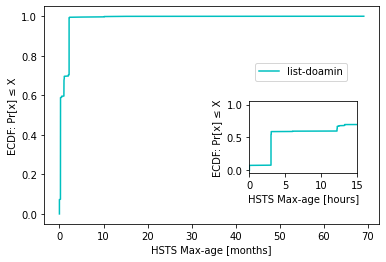

In [120]:
tum_blue = "#00C0C0"
tum_orange = "#4682B4"
monthsecs = 30*12
hoursecs = 30
# cdf(http_raw[http_raw["http-header--sts-max-age-valid"] == True]["http-header--sts-max-age"].astype(float)/monthsecs, label="list-doamin", color=tum_blue)
# #cdf(c[c["http-header--hpkp-max-age-valid"] == True]["http-header--hpkp-max-age"].astype(int), label="HPKP")
# cdf(email_raw[(email_raw["http-header--sts-max-age-valid"] == True)]["http-header--sts-max-age"].astype(float)/monthsecs, label="list-webmail", color=tum_orange, linestyle="dashed")
fig, ax = plt.subplots()

sample1 = all_raw["cert_lifetime"].astype(float)/monthsecs
                  
s1 = np.sort(sample1)
# sample2 = email_raw[(email_raw["http-header--sts-max-age-valid"] == True)]["http-header--sts-max-age"].astype(float)/monthsecs
# s2= np.sort(sample2)
ax.plot(s1,np.arange(len(s1))/float(len(s1)),color = tum_blue,label="list-doamin")
# ax.plot(s2,np.arange(len(s2))/float(len(s2)),color = tum_orange,label="list-webmail",linestyle="dashed")
#plt.xscale("log")
plt.xlabel('HSTS Max-age [months]')
plt.ylabel('ECDF: Pr[x] ≤ X')
#x1, x2, y1, y2 = plt.axis()
#plt.axis((x1, 1000, y1, y2))
axes = plt.gca()
# axes.set_xlim([0, 30])
# plt.xticks(np.arange(0, 30+1, 6))
plt.legend(loc =5,bbox_to_anchor=(0.92, 0.7))

sample3 = all_raw["cert_lifetime"].astype(float).astype(float)/hoursecs
s3 = np.sort(sample3)
# sample4 = email_raw[(email_raw["http-header--sts-max-age-valid"] == True)]["http-header--sts-max-age"].astype(float)/hoursecs
# s4= np.sort(sample4)


inset_ax = fig.add_axes([0.6, 0.3, 0.25, 0.25],facecolor="white")
inset_ax.set_xlim([0,15])
# inset_ax.set_ylim([0,0.4])
inset_ax.plot(s3,np.arange(len(s3))/float(len(s3)),color = tum_blue,label="list-doamin")
# inset_ax.plot(s4,np.arange(len(s4))/float(len(s4)),color = tum_orange,label="list-webmail",linestyle="dashed")
inset_ax.set_xlabel('HSTS Max-age [hours]')
inset_ax.set_ylabel('ECDF: Pr[x] ≤ X')

# plt.savefig("./HSTS-MAX-age.pdf")
plt.show()

### 分析zen公司

In [39]:
zen_org = all_raw[all_raw["domain"].str.contains("zen.net.uk")]
zen_org

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag


In [40]:
zen_org.to_csv("./zen_org.txt",index=None)
zen_org["cert_error"].value_counts()

Series([], Name: cert_error, dtype: int64)

In [41]:
lifetime_398 = all_raw[(all_raw["cert_lifetime"]<=398) & (all_raw["cert_lifetime"]>0)]
print("分析证书生命周期大于0小于等于398天的证书的CA")
for index,value in lifetime_398["caName"].value_counts().iteritems():
    if value >= 20:
        print(index,value,value/len(lifetime_398)*100)

分析证书生命周期大于0小于等于398天的证书的CA
["Let's Encrypt"] 907 74.89677952105697
['ZeroSSL'] 85 7.018992568125516
['TrustAsia Technologies, Inc.'] 65 5.367464905037159
['DigiCert Inc'] 52 4.293971924029727
['Sectigo Limited'] 33 2.725020644095789


### 分析org和ISP

In [42]:
print("org:")
for index,value in all_raw[all_raw["cert_lifetime"]<=398.0].org.value_counts().iteritems():
    if value >=30:
        print(index,value,"---",value/len(tls1_3)*100) 
print("---------————————————————————————")
print("ISP:")
for index,value in all_raw[all_raw["cert_lifetime"]<=398.0].org.value_counts().iteritems():
    if value >=30:
        print(index,value,"---",value/len(tls1_3)*100) 

org:
 110 --- 10.1010101010101
Hetzner 73 --- 6.703397612488522
Tencent cloud computing (Beijing) Co., Ltd. 35 --- 3.213957759412305
Vultr Holdings, LLC 33 --- 3.0303030303030303
Aliyun Computing Co., LTD 33 --- 3.0303030303030303
netcup GmbH 32 --- 2.938475665748393
---------————————————————————————
ISP:
 110 --- 10.1010101010101
Hetzner 73 --- 6.703397612488522
Tencent cloud computing (Beijing) Co., Ltd. 35 --- 3.213957759412305
Vultr Holdings, LLC 33 --- 3.0303030303030303
Aliyun Computing Co., LTD 33 --- 3.0303030303030303
netcup GmbH 32 --- 2.938475665748393


In [43]:
print("org:")
for index,value in all_raw[all_raw["cert_lifetime"]>=398.0].org.value_counts().iteritems():
    if value >=30:
        print(index,value,"---",value/len(tls1_3)*100) 
print("---------————————————————————————")
print("ISP:")
for index,value in all_raw[all_raw["cert_lifetime"]>=398.0].org.value_counts().iteritems():
    if value >=30:
        print(index,value,"---",value/len(tls1_3)*100) 

org:
DNS Anycast4 133 --- 12.213039485766759
DNS Anycast3 133 --- 12.213039485766759
DNS Anycast Cleanbrowsing Secondary 128 --- 11.753902662993571
DNS Anycast Cleanbrowsing 128 --- 11.753902662993571
---------————————————————————————
ISP:
DNS Anycast4 133 --- 12.213039485766759
DNS Anycast3 133 --- 12.213039485766759
DNS Anycast Cleanbrowsing Secondary 128 --- 11.753902662993571
DNS Anycast Cleanbrowsing 128 --- 11.753902662993571


## 整体分析CA 

In [44]:
for index,value in all_raw["caName"].value_counts().iteritems():
    if value > 20:
        print(index,value,value/all_num*100)

["Let's Encrypt"] 907 46.68039114770973
['GoDaddy.com, Inc.'] 565 29.07874420998456
none 153 7.874420998455996
['ZeroSSL'] 85 4.374678332475553
['TrustAsia Technologies, Inc.'] 65 3.3453422542460114
['DigiCert Inc'] 56 2.8821410190427175
['Sectigo Limited'] 38 1.9557385486361298


## 分析证书重用 

In [28]:
temp = all_raw[all_raw["raw_cert_chain"]!=""]
len(temp)

2244

In [30]:
cert_share_list = [] 
share_domain = 0
shart_cert = 0
for index,value in temp["raw_cert_chain"].value_counts().iteritems():
    if value > 10:
        print(value,value/len(all_raw)*100)
        cert_share_list.append(index)
        shart_cert = shart_cert + 1
        share_domain = share_domain + value
    elif value > 1:
        shart_cert = shart_cert + 1
        share_domain = share_domain + value
# cert_share_list
print("一共有{}域名共享证书，占比{:.2%}".format(share_domain,share_domain/len(temp)))
print("一共有{}证书被共享，占比{:.2%}".format(shart_cert,shart_cert/len(temp["raw_cert_chain"].value_counts())))

564 23.63788767812238
155 6.496227996647108
120 5.029337803855825
31 1.2992455993294216
24 1.0058675607711651
一共有1299域名共享证书，占比57.89%
一共有148证书被共享，占比13.54%


### 对重用比例较高的证书进行分析 

#### 1 

In [31]:
cert_share_1 = all_raw[all_raw["raw_cert_chain"]==cert_share_list[0]]
cert_share_1["org"].value_counts()
cert_share_1["isp"].value_counts()

DNS Anycast4                           133
DNS Anycast3                           133
DNS Anycast Cleanbrowsing Secondary    128
DNS Anycast Cleanbrowsing              127
Vultr Holdings, LLC                     12
QuadraNet                                4
Packet Host, Inc                         3
Cogent communications - IPENG            3
Equinix Services, Inc                    2
Choopa, LLC                              2
CleanBrowsing                            2
Digital Energy Technologies Limited      1
Vultr                                    1
SocialCode                               1
RMH Franchise Holdings                   1
CleanBrowsing, Inc                       1
Old Town Craftworks                      1
FranTech Solutions                       1
Cloudwebmanage IL TA                     1
TYO Vultr                                1
Packet Host, Inc.                        1
PSINet, Inc.                             1
Heficed                                  1
QuadraNet, 

Daniel Cid                               521
The Constant Company                      15
Cogent Communications                      7
Packet Host, Inc.                          6
QuadraNet Enterprises LLC                  6
The Constant Company, LLC                  2
Choopa                                     1
Digital Energy Technologies Ltd.           1
FranTech Solutions                         1
O.M.C. COMPUTERS & COMMUNICATIONS LTD      1
Digital Energy Technologies Chile SpA      1
Nocix, LLC                                 1
NTnet Operations Ltd.                      1
Name: isp, dtype: int64

In [32]:
cert_share_1["certValid"].value_counts()

True     561
False      3
Name: certValid, dtype: int64

In [33]:
cert_share_1[cert_share_1["certValid"]==False].cert_error

2120     x509: certificate is valid for *.cleanbrowsing...
5945     x509: certificate is valid for *.cleanbrowsing...
11056    x509: certificate is valid for *.cleanbrowsing...
Name: cert_error, dtype: object

In [127]:
all_raw[all_raw["isp"].str.contains("daniel")]

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag,grade_num
7,customfilter110-dns2.cleanbrowsing.org,185.228.169.110,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,False,False,False,Netherlands,daniel cid,dns anycast cleanbrowsing secondary,False,False,B
8,customfilter235-dns.cleanbrowsing.org,185.228.170.235,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,False,False,False,Germany,daniel cid,dns anycast3,False,False,B
34,customfilter122-dns.cleanbrowsing.org,185.228.168.122,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,False,False,False,United States,daniel cid,dns anycast cleanbrowsing,False,False,B
35,customfilter3-dns2.cleanbrowsing.org,185.228.169.3,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,False,False,False,Netherlands,daniel cid,dns anycast cleanbrowsing secondary,False,False,B
36,customfilter223-dns2.cleanbrowsing.org,185.228.171.223,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,False,False,False,Netherlands,daniel cid,dns anycast4,False,False,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10863,customfilter10-dns.cleanbrowsing.org,185.228.170.10,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,False,False,False,Germany,daniel cid,dns anycast3,False,False,B
11018,customfilter204-dns2.cleanbrowsing.org,185.228.169.204,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,False,False,False,Netherlands,daniel cid,dns anycast cleanbrowsing secondary,False,False,B
11517,customfilter23-dns.cleanbrowsing.org,185.228.168.23,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,False,False,False,United States,daniel cid,dns anycast cleanbrowsing,False,False,B
11538,security-filter2-dns2.cleanbrowsing.org,185.228.169.12,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,False,False,False,Netherlands,daniel cid,dns anycast cleanbrowsing secondary,False,False,B


# 对CT进行分析 

In [ ]:
def list_convert(arg):
    new_list = []
    for i in arg:
        if type(i) is not list:
            new_list.append(i)
        else:
            new_list.extend(list_convert(i))
    return new_list

## 分析sct传递方式

### 拥有SCT的任意一种传递方式的DOT个数（至少包含三种方式的其中一种） 

In [ ]:
have_sct = all_raw.query('tlsHave == True | certHave == True | ocspHave == True')
have_sct_num = have_sct.ip.count()
print('{}个域名有SCT，在全部DOT中占比{:.2%}'.format(have_sct_num, have_sct_num/len(all_raw)))

#### 拥有SCT的全部传递方式的DOT个数

In [ ]:
have_sct_all = all_raw.query('tlsHave == True & certHave == True & ocspHave == True').ip.count()
print('{}个域名含有全部SCT的传递方式，占比{:.2%}'.format(have_sct_all, have_sct_all/len(all_raw)))

#### 通过tls传播DOT的域名个数 

In [ ]:
sct_tls = all_raw[all_raw['tlsHave'] == True]
sct_tls_num = sct_tls.ip.count()
print('{}个域名通过tls传递SCT，占比{:.4%}'.format(sct_tls_num, sct_tls_num/len(all_raw)))
print("在支持CT的DOT中占比：{:.2%}".format(sct_tls_num/have_sct_num))

#### 通过cert传播DOT的域名个数 

In [ ]:
sct_cert = all_raw[all_raw['certHave'] == True]
sct_cert_num = sct_cert.ip.count()
print('{}个域名通过cert传递SCT，占比{:.4%}'.format(sct_cert_num, sct_cert_num/len(all_raw)))
print("在支持CT的DOT中占比：{:.2%}".format(sct_cert_num/have_sct_num))

#### 通过ocsp传播DOT的域名个数 

In [ ]:
sct_ocsp = all_raw[all_raw['ocspHave'] == True]
sct_ocsp_num = sct_ocsp.ip.count()
print('{}个域名通过ocsp传递SCT，占比{:.4%}'.format(sct_ocsp_num, sct_ocsp_num/len(all_raw)))
print("在支持CT的DOT中占比：{:.2%}".format(sct_ocsp_num/have_sct_num))

In [ ]:
sct_ocsp

## 分析拥有CT的CA 

In [53]:
print(have_sct["caName"].value_counts())
print("-------------------------------")
print(have_sct["caName"].value_counts()/len(have_sct)*100)

NameError: name 'have_sct' is not defined

## 分析sct有效性 

### 至少有一个sct验证成功

In [54]:
sct_valid = all_raw[all_raw['flagValid'] == True]
print("在所有DOT中，至少有一个sct有效的DOT：")
print(all_raw['flagValid'].value_counts())
print("-------------------------------")
print(all_raw['flagValid'].value_counts()/len(all_raw)*100)

print("**************************************")

print("在支持CT的DOT中：")
print(have_sct['flagValid'].value_counts())
print("-------------------------------")
print(have_sct['flagValid'].value_counts()/len(have_sct)*100)

在所有DOT中，至少有一个sct有效的DOT：
True     1745
False     198
Name: flagValid, dtype: int64
-------------------------------
True     89.809573
False    10.190427
Name: flagValid, dtype: float64
**************************************
在支持CT的DOT中：


NameError: name 'have_sct' is not defined

### 分析通过cert传递的sct的验证情况 

In [55]:
cert_valid_list = []
for index,value in sct_cert["cert_valid"].iteritems():
    temp = value.split("#||#")
    cert_valid_list.append(temp)
    
temp = list_convert(cert_valid_list)
sct_cert_verify =pd.Series(temp)
print("通过cert传递的所有sct的验证情况：")
print(sct_cert_verify.value_counts())
print("-------------------------------")
print(sct_cert_verify.value_counts()/len(temp)*100)

NameError: name 'sct_cert' is not defined

### 分析通过ocsp传递的sct的验证情况 

In [56]:
ocsp_valid_list = []
for index,value in sct_ocsp["cert_valid"].iteritems():
    temp = value.split("#||#")
    ocsp_valid_list.append(temp)
    
temp = list_convert(ocsp_valid_list)
sct_ocsp_verify =pd.Series(temp)
print("通过cert传递的所有sct的验证情况：")
print(sct_ocsp_verify.value_counts())
print("-------------------------------")
print(sct_ocsp_verify.value_counts()/len(temp)*100)

NameError: name 'sct_ocsp' is not defined

## 分析sct的logdescription 

### 分析通过cert传递的sct的log 

In [57]:
cert_log_list = []
for index,value in sct_cert["cert_log"].iteritems():
    temp = value.split("#||#")
    cert_log_list.append(temp)
    
temp = list_convert(cert_log_list)
cert_log =pd.Series(temp)
print(cert_log.value_counts())   #null即该域名有cert传递的sct，但是certvalid都为false。或第一个为flase,第二个为true
print("-------------------------------")
print(cert_log.value_counts()/len(temp)*100)

NameError: name 'sct_cert' is not defined

### 分析通过ocsp传递的sct的log 

In [58]:
ocsp_log_list = []
for index,value in sct_ocsp["cert_log"].iteritems():
    temp = value.split("#||#")
    ocsp_log_list.append(temp)
    
temp = list_convert(ocsp_log_list)
ocsp_log =pd.Series(temp)
print(ocsp_log.value_counts())   #null即该域名有cert传递的sct，但是certvalid都为false。或第一个为flase,第二个为true
print("-------------------------------")
print(ocsp_log.value_counts()/len(temp)*100)

NameError: name 'sct_ocsp' is not defined

### 分析整体的log

In [59]:
sct_log = pd.concat([cert_log, ocsp_log], axis=0,ignore_index=True)
print(sct_log.value_counts())
print("-------------------------------")
print(sct_log.value_counts()/len(sct_log)*100)

NameError: name 'cert_log' is not defined

### 整体分析log的多样性

In [60]:
log_list = []
for index,value in have_sct["cert_log"].iteritems():
    temp = value.split("#||#")
    log_list.append(temp)

for index,value in have_sct["ocsp_log"].iteritems():
    temp = value.split("#||#")
    log_list.append(temp)

log_num = len(log_list)    

log_more = 0
log_one = 0
one_google = 0
log_nan = 0
for item in log_list:
    if type(item) == list:
        uniq_item = list(set(item))  ##去重
        if len(uniq_item) >1:
            log_more += 1
        elif len(uniq_item) == 1:
            log_one += 1
            if "Google" in str(uniq_item[0]):
                one_google += 1
    else:
        log_nan += 1
            

print("在{}个sct的log中:".format(log_num))
print("有{}个sct有超过一个的log操作员,占比{:.2%}".format(log_more,log_more/log_num))
print("有{}个sct只有一个的log操作员,占比{:.2%}。其中google有{}个，占比{:.2%}".format(log_one,log_one/log_num,one_google,one_google/log_one))
print("剩余{}个没有获取到log操作员，占比{:.2%}".format(log_nan,log_nan/log_num))

NameError: name 'have_sct' is not defined

## 分析不支持CT的域名

### 整体分析没有sct的caname

In [61]:
no_sct = all_raw.query('tlsHave == False & certHave == False & ocspHave == False')
print("没有sct的域名共有：",no_sct.ip.count())
print(no_sct["caName"].value_counts())

没有sct的域名共有： 164
none                       153
['CloudFlare, Inc.']         2
['Apple Inc.']               1
['Meditem AB']               1
['ns1.root-dns.zone']        1
['Default Company Ltd']      1
['EK-DNS']                   1
['Thiessen.org']             1
['Careicon-Dev']             1
['Nagravision']              1
['Christopher Kleen']        1
Name: caName, dtype: int64


In [62]:
 for i in range(len(no_sct)):
        if no_sct.iloc[i]["caName"] != "none":
            for value in no_sct.iloc[i]["caName"]:
                if "Fortinet" in value:
                    print(no_sct.iloc[i]["domain"],no_sct.iloc[i]["ip"])

### 在证书有效的情况下，分析sct无效的域名 

In [63]:
%%time
Cert_valid_sctfalse = cert_valid[cert_valid['flagValid'] == False]
Cert_valid_sctfalse_num = Cert_valid_sctfalse.ip.count()
print("证书有效但sct无效的域名共有：",Cert_valid_sctfalse_num)
Cert_valid_sctfalse

证书有效但sct无效的域名共有： 2
Wall time: 2 ms


,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
6265,dns.leonardo.tec.br,150.136.0.232,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdTVE...,DV,True,[Sectigo Limited],True,...,none,none,True,False,False,United States,Oracle Corporation,Oracle Cloud Infrastructure (us-ashburn-1),False,False
11421,tlsdns.xuanlove.cn,1.117.174.35,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdFRE...,DV,True,"[TrustAsia Technologies, Inc.]",True,...,none,none,True,False,False,China,China Internet Network Information Center,"Tencent cloud computing (Beijing) Co., Ltd.",False,False


In [64]:
Cert_valid_sctfalse["caName"]

6265                  [Sectigo Limited]
11421    [TrustAsia Technologies, Inc.]
Name: caName, dtype: object

## 分析EV证书的CT

In [65]:
EVcert

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
2308,www.dns.oryxlabs.com,99.83.165.15,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUlKVE...,EV,True,[Digital Trust L.L.C.],True,...,none,none,False,False,False,United States,"Amazon.com, Inc.",AWS Global Accelerator (GLOBAL),False,False
9102,dns.oryxlabs.com,45.152.135.135,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUlKVE...,EV,True,[Digital Trust L.L.C.],True,...,none,none,True,True,True,United Arab Emirates,"Amazon.com, Inc.",Oryxlabs Technologies - Sole Proprietorship L.L.C,False,False


In [66]:
EVcert["flagValid"]
EVcert["caName"]
EVcert["cert_log"]

2308    True
9102    True
Name: flagValid, dtype: bool

2308    [Digital Trust L.L.C.]
9102    [Digital Trust L.L.C.]
Name: caName, dtype: object

2308    Google 'Xenon2022' log#||#Sectigo 'Sabre' CT l...
9102    Google 'Xenon2022' log#||#Sectigo 'Sabre' CT l...
Name: cert_log, dtype: object

# 对证书撤销进行分析 

In [67]:
all_raw.keys()

Index(['domain', 'ip', 'tlsVersion', 'scsv', 'connError', 'raw_cert_chain',
       'cert_level', 'certValid', 'caName', 'time_valid', 'cert_lifetime',
       'cert_error', 'tlsHave', 'sct_tls_valid', 'tls_log', 'certHave',
       'cert_valid', 'cert_log', 'ocspHave', 'ocsp_valid', 'ocsp_log',
       'flagValid', 'crLs', 'crl_server', 'ocsp', 'ocspServer', 'ocspStapling',
       'ocspMustStaple', 'respect_ms', 'response_flag', 'crl_cert_status',
       'crl_response_sig', 'ocsp_cert_status', 'ocsp_response_sig',
       'ocsp_stapling_cert_status', 'ocsp_stapling_response_sig',
       'tlsa_dnssec', 'caa_dnssec', 'caa_result', 'dnssec', 'dane', 'dane_err',
       'tls13_down_12', 'tls13_down_11', 'tls13_down_10', 'country', 'isp',
       'org', 'tlsa_flag', 'caa_flag'],
      dtype='object')

## 分析证书撤销方式 

### 整体分析 

In [68]:
have_crl = all_raw[all_raw["crLs"] == True]
have_ocsp = all_raw[all_raw["ocsp"] == True]
have_ocspsl = all_raw[all_raw["ocspStapling"] == True]
have_ocspms = all_raw[all_raw["ocspMustStaple"] == True]
print("在所有DOT中：")
print("CRL传递方式")
print(all_raw["crLs"].value_counts())
print("-------------------------------")
print(all_raw["crLs"].value_counts()/all_num*100)
print("**************************************")
print("OCSP传递方式")
print(all_raw["ocsp"].value_counts())
print("-------------------------------")
print(all_raw["ocsp"].value_counts()/all_num*100)
print("**************************************")
print("ocspStapling传递方式")
print(all_raw["ocspStapling"].value_counts())
print("-------------------------------")
print(all_raw["ocspStapling"].value_counts()/all_num*100)
print("**************************************")
print("ocspMustStaple传递方式")
print(all_raw["ocspMustStaple"].value_counts())
print("-------------------------------")
print(all_raw["ocspMustStaple"].value_counts()/all_num*100)

在所有DOT中：
CRL传递方式
False    1287
True      656
Name: crLs, dtype: int64
-------------------------------
False    66.237777
True     33.762223
Name: crLs, dtype: float64
**************************************
OCSP传递方式
True     1780
False     163
Name: ocsp, dtype: int64
-------------------------------
True     91.610911
False     8.389089
Name: ocsp, dtype: float64
**************************************
ocspStapling传递方式
False    1886
True       57
Name: ocspStapling, dtype: int64
-------------------------------
False    97.066392
True      2.933608
Name: ocspStapling, dtype: float64
**************************************
ocspMustStaple传递方式
False    1913
True       30
Name: ocspMustStaple, dtype: int64
-------------------------------
False    98.455996
True      1.544004
Name: ocspMustStaple, dtype: float64


### 分析支持证书撤销的DOT 

In [69]:
have_revoke = all_raw[(all_raw["crLs"]==True) | (all_raw["ocsp"]==True) | (all_raw["ocspStapling"]==True) | (all_raw["ocspMustStaple"]==True)]
print("在所有DOT中，支持证书撤销的有：{}, 占比{:.2%}".format(len(have_revoke), len(have_revoke)/all_num))
have_revoke

在所有DOT中，支持证书撤销的有：1783, 占比91.77%


,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
0,1dot1dot1dot1.cloudflare-dns.com,1.0.0.1,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,['DigiCert Inc'],True,...,none,none,True,False,False,Australia,"Cloudflare, Inc",APNIC and Cloudflare DNS Resolver project,False,False
1,dns3.dnsfilter.com,147.75.94.119,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZaak...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,True,True,United States,"Packet Host, Inc.","Packet Host, Inc",False,False
2,cloudflare-dns.com,162.159.36.16,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,['DigiCert Inc'],True,...,none,none,False,False,False,Canada,"Cloudflare, Inc.","Cloudflare, Inc.",False,False
6,freedns.controld.dev,176.125.239.4,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdoVE...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Canada,Windscribe,Zenu Software LLC,False,False
7,customfilter110-dns2.cleanbrowsing.org,185.228.169.110,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,none,False,False,False,Netherlands,Daniel Cid,DNS Anycast Cleanbrowsing Secondary,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11631,security-filter-dns2.cleanbrowsing.org,185.228.169.9,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,none,False,False,False,Netherlands,Daniel Cid,DNS Anycast Cleanbrowsing Secondary,False,False
11643,dns2.nodoa.me,45.63.127.24,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVZak...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Japan,The Constant Company,"Vultr Holdings, LLC",False,False
11651,hemmelder01.duckdns.org,86.81.245.70,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUV0RE...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Netherlands,KPN B.V.,,False,False
11679,dns-edge-asia-seoul.cleanbrowsing.org,158.247.196.17,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,none,False,False,False,South Korea,"The Constant Company, LLC","Choopa, LLC",False,False


### 只有CRL的情况

In [70]:
only_crl = all_raw[(all_raw["crLs"]==True) & (all_raw["ocsp"]==False) & (all_raw["ocspStapling"]==False) & (all_raw["ocspMustStaple"]==False)]
print("在所有DOT中，只支持CRL的有：{}, 占比{:.2%}".format(len(only_crl), len(only_crl)/all_num))
only_crl

在所有DOT中，只支持CRL的有：3, 占比0.15%


,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
4953,meddns.meditem.se,212.112.62.51,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUcrRE...,UnknownValidationLevel,False,['Meditem AB'],True,...,none,none,True,True,True,Sweden,LIDNET,Lidero Network AB,False,False
5675,tx.dnsjj.online,101.34.0.13,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUV0VE...,UnknownValidationLevel,False,"['CloudFlare, Inc.']",True,...,none,none,False,False,False,China,Shenzhen Tencent Computer Systems Company Limited,"Tencent Cloud Computing (Beijing) Co., Ltd",False,False
7172,dnsjj.online,101.34.0.13,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUV0VE...,UnknownValidationLevel,False,"['CloudFlare, Inc.']",True,...,none,none,False,False,False,China,Shenzhen Tencent Computer Systems Company Limited,"Tencent Cloud Computing (Beijing) Co., Ltd",False,False


### 只有CRL或OCSP的情况

In [71]:
only_crl_ocsp = all_raw[((all_raw["crLs"]==True) | (all_raw["ocsp"]==True)) & (all_raw["ocspStapling"]==False) & (all_raw["ocspMustStaple"]==False)]
print("在所有DOT中，只支持CRL或OCSP的有：{}, 占比{:.2%}".format(len(only_crl_ocsp), len(only_crl_ocsp)/all_num))
only_crl_ocsp

在所有DOT中，只支持CRL或OCSP的有：1713, 占比88.16%


,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
0,1dot1dot1dot1.cloudflare-dns.com,1.0.0.1,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,['DigiCert Inc'],True,...,none,none,True,False,False,Australia,"Cloudflare, Inc",APNIC and Cloudflare DNS Resolver project,False,False
1,dns3.dnsfilter.com,147.75.94.119,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZaak...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,True,True,United States,"Packet Host, Inc.","Packet Host, Inc",False,False
2,cloudflare-dns.com,162.159.36.16,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,['DigiCert Inc'],True,...,none,none,False,False,False,Canada,"Cloudflare, Inc.","Cloudflare, Inc.",False,False
6,freedns.controld.dev,176.125.239.4,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdoVE...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Canada,Windscribe,Zenu Software LLC,False,False
7,customfilter110-dns2.cleanbrowsing.org,185.228.169.110,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,none,False,False,False,Netherlands,Daniel Cid,DNS Anycast Cleanbrowsing Secondary,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11631,security-filter-dns2.cleanbrowsing.org,185.228.169.9,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,none,False,False,False,Netherlands,Daniel Cid,DNS Anycast Cleanbrowsing Secondary,False,False
11643,dns2.nodoa.me,45.63.127.24,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVZak...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Japan,The Constant Company,"Vultr Holdings, LLC",False,False
11651,hemmelder01.duckdns.org,86.81.245.70,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUV0RE...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Netherlands,KPN B.V.,,False,False
11679,dns-edge-asia-seoul.cleanbrowsing.org,158.247.196.17,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,none,none,False,False,False,South Korea,"The Constant Company, LLC","Choopa, LLC",False,False


### 分析OCSP Must-Staple 

In [72]:
print("在支持ocspMustStaple的DOT中，提供OCSPStapling的有：")
print(have_ocspms["respect_ms"].value_counts())
print("-------------------------------")
print(have_ocspms["respect_ms"].value_counts()/len(have_ocspms)*100)

在支持ocspMustStaple的DOT中，提供OCSPStapling的有：
True     17
False    13
Name: respect_ms, dtype: int64
-------------------------------
True     56.666667
False    43.333333
Name: respect_ms, dtype: float64


In [73]:
print("org")
have_ocspms["org"].value_counts()
print("isp")
have_ocspms["isp"].value_counts()

org


Hetzner                          5
nextdns, Inc.                    4
1&1 Internet Inc.                3
DigitalOcean, LLC                3
netcup GmbH                      3
Ionos                            3
NextDNS, Inc                     2
nextdns, Inc                     2
HETZNER-DC                       2
Linode                           1
tavu.io Public Cloud Services    1
hangugtongsindaegubonbu          1
Name: org, dtype: int64

isp


Hetzner Online GmbH    7
IONOS SE               6
nextdns, Inc.          4
nextdns                4
DigitalOcean, LLC      3
netcup GmbH            3
Linode, LLC            1
Multim Oy              1
KORNET                 1
Name: isp, dtype: int64

#### 在有OCSP Must-Staple的情况下是否提供OCSP Stapling

In [74]:
respect_ms = have_ocspms[have_ocspms["respect_ms"]==True]
respect_ms

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
9,dns.nextdns.io,185.253.5.105,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVJek...,DV,True,['ZeroSSL'],True,...,none,none,True,False,False,Germany,"nextdns, Inc.","NextDNS, Inc",False,False
10,ams-1.edge.nextdns.io,185.253.5.58,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUR6ek...,DV,True,"[""Let's Encrypt""]",True,...,none,none,False,False,False,Germany,"nextdns, Inc.","NextDNS, Inc",False,False
13,ewr-1.edge.nextdns.io,23.247.212.197,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUR6ek...,DV,True,"[""Let's Encrypt""]",True,...,none,none,False,False,False,United States,nextdns,"nextdns, Inc.",False,False
19,dns1.nextdns.io,45.90.28.235,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVKak...,DV,True,['ZeroSSL'],True,...,none,none,True,False,False,United States,"nextdns, Inc.","nextdns, Inc",False,False
72,dal-1.edge.nextdns.io,23.247.215.225,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUR6ek...,DV,True,"[""Let's Encrypt""]",True,...,none,none,False,False,False,United States,nextdns,"nextdns, Inc.",False,False
97,dns2.nextdns.io,45.90.30.123,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVLVE...,DV,True,['ZeroSSL'],True,...,none,none,True,False,False,United States,"nextdns, Inc.","nextdns, Inc",False,False
139,lax-1.edge.nextdns.io,23.247.214.117,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUR6ek...,DV,True,"[""Let's Encrypt""]",True,...,none,none,False,False,False,France,nextdns,"nextdns, Inc.",False,False
230,chi-1.edge.nextdns.io,23.247.213.26,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUR6ek...,DV,True,"[""Let's Encrypt""]",True,...,none,none,False,False,False,United States,nextdns,"nextdns, Inc.",False,False
803,do-sfo-1.edge.nextdns.io,143.110.229.87,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUR6ek...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,United States,"DigitalOcean, LLC","DigitalOcean, LLC",False,False
1056,phdns1.lonet.org,185.183.156.85,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdlak...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Germany,netcup GmbH,netcup GmbH,False,True


In [75]:
respect_no_ms = have_ocspms[have_ocspms["respect_ms"]==False]
respect_no_ms

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
214,dns.kromlinger.eu,116.202.183.232,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdXRE...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Germany,Hetzner Online GmbH,Hetzner,False,False
731,phdns3.lonet.org,74.208.85.60,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdlak...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,United States,IONOS SE,1&1 Internet Inc.,False,True
1050,dns.hash.works,116.202.183.232,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdXRE...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Germany,Hetzner Online GmbH,Hetzner,False,False
1902,dns.glados.whafs.de,144.76.28.35,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVtRE...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Germany,Hetzner Online GmbH,Hetzner,False,True
2416,ipv4.phdns3.lonet.org,74.208.85.60,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdlak...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,United States,IONOS SE,1&1 Internet Inc.,False,False
2580,ordns.2wi.nl,172.104.104.37,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUhpVE...,DV,True,['ZeroSSL'],True,...,none,none,True,False,False,Japan,"Linode, LLC",Linode,False,False
3259,dns.jarvis.whafs.de,144.76.62.69,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVsek...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Germany,Hetzner Online GmbH,Hetzner,False,False
6073,ipv6.phdns3.lonet.org,74.208.85.60,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdlak...,DV,True,"[""Let's Encrypt""]",True,...,none,none,False,False,False,United States,IONOS SE,1&1 Internet Inc.,False,False
7065,dot.vaioswolke.xyz,135.181.144.157,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVjak...,DV,True,"[""Let's Encrypt""]",True,...,none,none,True,False,False,Finland,Hetzner Online GmbH,HETZNER-DC,False,False
7281,dns.dateno1.com,125.137.227.31,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUhBek...,DV,True,"[""Let's Encrypt""]",True,...,none,none,False,False,False,South Korea,KORNET,hangugtongsindaegubonbu,False,False


#### 支持ocsp must-staple，不提供ocspstapling的org和ISP 

In [76]:
print("org")
respect_no_ms["org"].value_counts()
print("isp")
respect_no_ms["isp"].value_counts()

org


Hetzner                    5
1&1 Internet Inc.          3
HETZNER-DC                 2
Linode                     1
hangugtongsindaegubonbu    1
DigitalOcean, LLC          1
Name: org, dtype: int64

isp


Hetzner Online GmbH    7
IONOS SE               3
Linode, LLC            1
KORNET                 1
DigitalOcean, LLC      1
Name: isp, dtype: int64

## 从证书撤销角度分析CA 

In [77]:
print("CRL:")
for index,value in have_crl["caName"].value_counts().iteritems():
    if value >= 10:
        print(index,value,value/len(have_crl)*100) 

print("-------------------")

print("OCSP:")
for index,value in have_ocsp["caName"].value_counts().iteritems():
    if value >= 10:
        print(index,value,value/len(have_ocsp)*100) 

print("-------------------")

print("OCSPStapling:")
for index,value in have_ocspsl["caName"].value_counts().iteritems():
    print(index,value,value/len(have_ocspsl)*100) 

print("-------------------")

print("OCSP Must-Staple:")
for index,value in have_ocspms["caName"].value_counts().iteritems():
    print(index,value,value/len(have_ocspms)*100) 

CRL:
['GoDaddy.com, Inc.'] 565 86.1280487804878
['DigiCert Inc'] 31 4.725609756097561
['Buypass AS-983163327'] 13 1.9817073170731707
-------------------
OCSP:
["Let's Encrypt"] 907 50.95505617977528
['GoDaddy.com, Inc.'] 565 31.741573033707866
['ZeroSSL'] 85 4.775280898876404
['TrustAsia Technologies, Inc.'] 65 3.651685393258427
['DigiCert Inc'] 56 3.146067415730337
['Sectigo Limited'] 38 2.134831460674157
['Buypass AS-983163327'] 13 0.7303370786516854
['GlobalSign nv-sa'] 13 0.7303370786516854
-------------------
OCSPStapling:
["Let's Encrypt"] 46 80.7017543859649
['ZeroSSL'] 4 7.017543859649122
['DigiCert Inc'] 4 7.017543859649122
['Cloudflare, Inc.'] 3 5.263157894736842
-------------------
OCSP Must-Staple:
["Let's Encrypt"] 26 86.66666666666667
['ZeroSSL'] 4 13.333333333333334


## 从证书撤销角度分析org

In [78]:
print("CRL:")
for index,value in have_crl["org"].value_counts().iteritems():
    if value >= 10:
        print(index,value,value/len(have_crl)*100) 

print("-------------------")

print("OCSP:")
for index,value in have_ocsp["org"].value_counts().iteritems():
    if value >= 20:
        print(index,value,value/len(have_ocsp)*100) 

print("-------------------")

print("OCSPStapling:")
for index,value in have_ocspsl["org"].value_counts().iteritems():
    print(index,value,value/len(have_ocspsl)*100) 

print("-------------------")

print("OCSP Must-Staple:")
for index,value in have_ocspms["org"].value_counts().iteritems():
    print(index,value,value/len(have_ocspms)*100) 

CRL:
DNS Anycast3 133 20.27439024390244
DNS Anycast4 133 20.27439024390244
DNS Anycast Cleanbrowsing Secondary 128 19.51219512195122
DNS Anycast Cleanbrowsing 128 19.51219512195122
Vultr Holdings, LLC 13 1.9817073170731707
-------------------
OCSP:
DNS Anycast3 133 7.47191011235955
DNS Anycast4 133 7.47191011235955
DNS Anycast Cleanbrowsing Secondary 128 7.191011235955057
DNS Anycast Cleanbrowsing 128 7.191011235955057
 97 5.44943820224719
Hetzner 70 3.932584269662921
Vultr Holdings, LLC 45 2.528089887640449
Tencent cloud computing (Beijing) Co., Ltd. 35 1.9662921348314606
netcup GmbH 32 1.7977528089887642
DigitalOcean, LLC 25 1.4044943820224718
Linode 25 1.4044943820224718
Aliyun Computing Co., LTD 22 1.2359550561797752
-------------------
OCSPStapling:
Kracon ApS 7 12.280701754385964
nextdns, Inc. 4 7.017543859649122
Fasthosts Internet Limited 4 7.017543859649122
 4 7.017543859649122
Danmarks Tekniske Universitet 4 7.017543859649122
WEBPARTNER 4 7.017543859649122
Cloudflare, Inc. 3 5

## 分析CRL 和 OCSP Server 

In [79]:
print("CRL Server")
for index,value in have_crl["crl_server"].value_counts().iteritems():
    if value >= 10:
        print(index,value,value/len(have_crl)*100) 
print("------------------------------------------------------")
print("OCSP Server：")
for index,value in have_ocsp["ocspServer"].value_counts().iteritems():
    if value >= 10:
        print(index,value,value/len(have_ocsp)*100) 

CRL Server
['http://crl.godaddy.com/gdig2s1-2020.crl'] 561 85.51829268292683
['http://crl.buypass.no/crl/BPClass2CA5.crl'] 13 1.9817073170731707
['http://crl3.digicert.com/DigiCertTLSHybridECCSHA3842020CA1-1.crl', 'http://crl4.digicert.com/DigiCertTLSHybridECCSHA3842020CA1-1.crl'] 10 1.524390243902439
------------------------------------------------------
OCSP Server：
['http://r3.o.lencr.org'] 878 49.325842696629216
['http://ocsp.godaddy.com/'] 565 31.741573033707866
['http://zerossl.ocsp.sectigo.com'] 85 4.775280898876404
['http://statuse.digitalcertvalidation.com'] 56 3.146067415730337
['http://ocsp.digicert.com'] 50 2.8089887640449436
['http://ocsp.sectigo.com'] 38 2.134831460674157
['http://ocsp.int-x3.letsencrypt.org'] 18 1.0112359550561798
['http://ocsp.buypass.com'] 13 0.7303370786516854
['http://ocsp.usertrust.com'] 13 0.7303370786516854
['http://e1.o.lencr.org'] 11 0.6179775280898876


## 分析撤销响应 

### 整体分析 

In [80]:
all_raw.keys()

Index(['domain', 'ip', 'tlsVersion', 'scsv', 'connError', 'raw_cert_chain',
       'cert_level', 'certValid', 'caName', 'time_valid', 'cert_lifetime',
       'cert_error', 'tlsHave', 'sct_tls_valid', 'tls_log', 'certHave',
       'cert_valid', 'cert_log', 'ocspHave', 'ocsp_valid', 'ocsp_log',
       'flagValid', 'crLs', 'crl_server', 'ocsp', 'ocspServer', 'ocspStapling',
       'ocspMustStaple', 'respect_ms', 'response_flag', 'crl_cert_status',
       'crl_response_sig', 'ocsp_cert_status', 'ocsp_response_sig',
       'ocsp_stapling_cert_status', 'ocsp_stapling_response_sig',
       'tlsa_dnssec', 'caa_dnssec', 'caa_result', 'dnssec', 'dane', 'dane_err',
       'tls13_down_12', 'tls13_down_11', 'tls13_down_10', 'country', 'isp',
       'org', 'tlsa_flag', 'caa_flag'],
      dtype='object')

In [81]:
print("在所有DOT中，可以获取到撤销响应有：")
print(all_raw["response_flag"].value_counts())
print("-------------------------------")
print(all_raw["response_flag"].value_counts()/all_num*100)


在所有DOT中，可以获取到撤销响应有：
True     1619
False     324
Name: response_flag, dtype: int64
-------------------------------
True     83.324756
False    16.675244
Name: response_flag, dtype: float64


In [82]:
print("在支持证书撤销的DOT中，可以获取到撤销响应有：")
print(have_revoke["response_flag"].value_counts())
print("-------------------------------")
print(have_revoke["response_flag"].value_counts()/len(have_revoke)*100)

在支持证书撤销的DOT中，可以获取到撤销响应有：
True     1619
False     164
Name: response_flag, dtype: int64
-------------------------------
True     90.802019
False     9.197981
Name: response_flag, dtype: float64


### 分析证书状态 

#### 查看有多少证书被撤销 

In [83]:
revoked = all_raw[(all_raw["crl_cert_status"]=="Revoked")|(all_raw["ocsp_cert_status"]=="Revoked")|(all_raw["ocsp_stapling_cert_status"]=="Revoked")]
revoked

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
87,dot.sb,194.169.181.35,TLSv1.2,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdGak...,DV,True,['GoGetSSL'],True,...,none,none,False,False,False,Netherlands,xTom GmbH,xTom GmbH,False,False
5583,dns2.lm379.ga,101.32.190.142,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdCak...,DV,True,"['TrustAsia Technologies, Inc.']",True,...,none,none,True,False,False,Hong Kong,Shenzhen Tencent Computer Systems Company Limited,Acevillepteltd SG,False,False


In [84]:
all_raw["crl_cert_status"].value_counts()
all_raw["ocsp_cert_status"].value_counts()
all_raw["ocsp_stapling_cert_status"].value_counts()

         1287
Good      654
Error       2
Name: crl_cert_status, dtype: int64

Good       1606
Error       172
            163
Revoked       2
Name: ocsp_cert_status, dtype: int64

        1886
Good      57
Name: ocsp_stapling_cert_status, dtype: int64

#### 分析不同撤销机制的差异 

In [85]:
print("CRL和OCSP差异:")
revoked[((revoked["crl_cert_status"]=="Good")&(revoked["ocsp_cert_status"]=="Revoked"))|((revoked["crl_cert_status"]=="Revoked")&(revoked["ocsp_cert_status"]=="Good"))]
print("CRL和OCSPstapling差异:")
revoked[((revoked["crl_cert_status"]=="Good")&(revoked["ocsp_stapling_cert_status"]=="Revoked"))|((revoked["crl_cert_status"]=="Revoked")&(revoked["ocsp_stapling_cert_status"]=="Good"))]
print("OCSPstapling和OCSP差异:")
revoked[((revoked["ocsp_stapling_cert_status"]=="Good")&(revoked["ocsp_cert_status"]=="Revoked"))|((revoked["ocsp_stapling_cert_status"]=="Revoked")&(revoked["ocsp_cert_status"]=="Good"))]

CRL和OCSP差异:


,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
87,dot.sb,194.169.181.35,TLSv1.2,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdGak...,DV,True,['GoGetSSL'],True,...,none,none,False,False,False,Netherlands,xTom GmbH,xTom GmbH,False,False


CRL和OCSPstapling差异:


,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag


OCSPstapling和OCSP差异:


,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag


## 分析撤销响应的签名 

In [86]:
print("CRL响应签名：")
print(have_crl["crl_response_sig"].value_counts())
print("-------------------------------")
print(have_crl["crl_response_sig"].value_counts()/len(have_crl)*100)
print("**************************************")
print("OCSP响应签名")
print(have_ocsp["ocsp_response_sig"].value_counts())
print("-------------------------------")
print(have_ocsp["ocsp_response_sig"].value_counts()/len(have_ocsp)*100)
print("**************************************")
print("OCSPStapling响应签名")
print(have_ocspsl["ocsp_stapling_response_sig"].value_counts())
print("-------------------------------")
print(have_ocspsl["ocsp_stapling_response_sig"].value_counts()/len(have_ocspsl)*100)

CRL响应签名：
True     652
False      4
Name: crl_response_sig, dtype: int64
-------------------------------
True     99.390244
False     0.609756
Name: crl_response_sig, dtype: float64
**************************************
OCSP响应签名
True     1008
False     772
Name: ocsp_response_sig, dtype: int64
-------------------------------
True     56.629213
False    43.370787
Name: ocsp_response_sig, dtype: float64
**************************************
OCSPStapling响应签名
True    57
Name: ocsp_stapling_response_sig, dtype: int64
-------------------------------
True    100.0
Name: ocsp_stapling_response_sig, dtype: float64


### 分析签名的CA 

In [87]:
print("CRL响应签名正确的CA")
for index,value in have_crl[have_crl["crl_response_sig"]==True].caName.value_counts().iteritems():
    if value >= 10:
        print(index,value,value/len(have_crl)*100) 
        
print("**************************************")

print("CRL响应签名错误的CA")
for index,value in have_crl[have_crl["crl_response_sig"]==False].caName.value_counts().iteritems():
    print(index,value,value/len(have_crl)*100)

print("**************************************")

print("OCSP响应签名正确的CA")
for index,value in have_ocsp[have_ocsp["crl_response_sig"]==True].caName.value_counts().iteritems():
    if value >= 10:
        print(index,value,value/len(have_ocsp)*100) 
        
print("**************************************")

print("OCSP响应签名错误的CA")
for index,value in have_ocsp[have_ocsp["crl_response_sig"]==False].caName.value_counts().iteritems():
    print(index,value,value/len(have_ocsp)*100)

CRL响应签名正确的CA
['GoDaddy.com, Inc.'] 565 86.1280487804878
['DigiCert Inc'] 31 4.725609756097561
['Buypass AS-983163327'] 13 1.9817073170731707
**************************************
CRL响应签名错误的CA
['CloudFlare, Inc.'] 2 0.3048780487804878
['Meditem AB'] 1 0.1524390243902439
none 1 0.1524390243902439
**************************************
OCSP响应签名正确的CA
['GoDaddy.com, Inc.'] 565 31.741573033707866
['DigiCert Inc'] 31 1.741573033707865
['Buypass AS-983163327'] 13 0.7303370786516854
**************************************
OCSP响应签名错误的CA
["Let's Encrypt"] 907 50.95505617977528
['ZeroSSL'] 85 4.775280898876404
['TrustAsia Technologies, Inc.'] 65 3.651685393258427
['Sectigo Limited'] 38 2.134831460674157
['DigiCert Inc'] 25 1.4044943820224718
['GlobalSign nv-sa'] 4 0.22471910112359553
['TrustOcean Limited'] 3 0.16853932584269662
none 1 0.05617977528089888


# 对DANE-TLSA进行分析 

## dnssec

In [129]:
dnssec_raw = pd.read_csv("./EDNS(0)-DNSSEC/result_analysis.txt")
dnssec_raw = pd.DataFrame(dnssec_raw,columns = ['ip','dnssec'])

dnssec_raw

,ip,dnssec
0,165.84.169.145,False
1,61.216.59.194,True
2,162.159.46.1,True
3,172.64.36.164,True
4,162.159.36.96,True
...,...,...
17798,119.3.92.152,False
17799,77.237.76.90,True
17800,164.132.212.102,True
17801,83.233.3.106,False


In [130]:
all_raw = pd.merge(all_raw,dnssec_raw,on=["ip"],how="left")
all_raw

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag,grade_num,dnssec_y
0,1dot1dot1dot1.cloudflare-dns.com,1.0.0.1,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,['DigiCert Inc'],True,...,True,False,False,Australia,"cloudflare, inc",apnic and cloudflare dns resolver project,False,False,A,True
1,dns3.dnsfilter.com,147.75.94.119,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZaak...,DV,True,"[""Let's Encrypt""]",True,...,True,True,True,United States,"packet host, inc.","packet host, inc",False,False,A,False
2,cloudflare-dns.com,162.159.36.16,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,['DigiCert Inc'],True,...,False,False,False,Canada,"cloudflare, inc.","cloudflare, inc.",False,False,B,True
3,com.apple.dnssd-proxy,175.119.23.36,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUNzVE...,UnknownValidationLevel,False,['Apple Inc.'],True,...,False,False,False,South Korea,sk broadband co ltd,sk broadband co ltd,False,False,C,False
4,freedns.controld.dev,176.125.239.4,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdoVE...,DV,True,"[""Let's Encrypt""]",True,...,True,False,False,Canada,windscribe,zenu software llc,False,False,A,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,dns2.nodoa.me,45.63.127.24,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVZak...,DV,True,"[""Let's Encrypt""]",True,...,True,False,False,Japan,the constant company,"vultr holdings, llc",False,False,A,True
1939,hemmelder01.duckdns.org,86.81.245.70,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUV0RE...,DV,True,"[""Let's Encrypt""]",True,...,True,False,False,Netherlands,kpn b.v.,,False,False,A,True
1940,dns.fadaige.xyz,101.132.168.152,,False,dial tcp 101.132.168.152:853: connect: no rout...,,,False,none,False,...,False,False,False,China,hangzhou alibaba advertising co,"aliyun computing co., ltd",False,False,C,False
1941,dns-edge-asia-seoul.cleanbrowsing.org,158.247.196.17,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"['GoDaddy.com, Inc.']",True,...,False,False,False,South Korea,"the constant company, llc","choopa, llc",False,False,B,True


In [133]:
have_dnssec = all_raw[all_raw["dnssec_y"]==True]
print("在所有DOT中，拥有受DNSSEC保护的TLSA记录的有：{}, 占比{:.2%}".format(len(have_dnssec), len(have_dnssec)/all_num))


在所有DOT中，拥有受DNSSEC保护的TLSA记录的有：1488, 占比76.58%


## 分析DOT的TLSA

In [88]:
have_tlsa = all_raw[all_raw["tlsa_flag"]==True]
print("在所有DOT中，拥有TLSA记录的有：{}, 占比{:.2%}".format(len(have_tlsa), len(have_tlsa)/all_num))
tlsa_dnssec = all_raw[(all_raw["tlsa_flag"]==True)&(all_raw["tlsa_dnssec"]=="Secure")]
print("在所有DOT中，拥有受DNSSEC保护的TLSA记录的有：{}, 占比{:.2%}".format(len(tlsa_dnssec), len(tlsa_dnssec)/all_num))
print("在有TLSA记录的DOT中，拥有受DNSSEC保护的TLSA记录的有：{}, 占比{:.2%}".format(len(tlsa_dnssec), len(tlsa_dnssec)/len(have_tlsa)))
print("受DNSSEC保护的TLSA")
tlsa_dnssec

在所有DOT中，拥有TLSA记录的有：48, 占比2.47%
在所有DOT中，拥有受DNSSEC保护的TLSA记录的有：46, 占比2.37%
在有TLSA记录的DOT中，拥有受DNSSEC保护的TLSA记录的有：46, 占比95.83%
受DNSSEC保护的TLSA


,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
251,dot1.appliedprivacy.net,146.255.56.102,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZFek...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Austria,Nessus GmbH,Applied Privacy,True,False
528,rgnet-iad.anycast.censurfridns.nu,198.180.150.12,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZjak...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,United States,RGnet OU,RGnet OU,True,False
752,dns.cybersafellc.com,23.239.21.33,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVmek...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,United States,"Linode, LLC",Linode,True,False
1173,dns.mjniessen.com,46.38.239.139,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZiak...,DV,False,"[""Let's Encrypt""]",False,...,False,match_err,True,False,False,Germany,netcup GmbH,NETCUP-GMBH,True,False
1712,unicast.uncensoreddns.org,89.233.43.71,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUUxRE...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Denmark,Telia Company AB,WEBPARTNER,True,False
1724,anycast.uncensoreddns.dk,185.38.27.139,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZZVE...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Denmark,Kracon ApS,Kracon ApS,True,False
1784,getdnsapi.net,185.49.141.37,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZuVE...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Netherlands,Infracom Holding B.V.,Stichting NLnet Labs,True,False
1831,unicast.censurfridns.nu,89.233.43.71,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUUxRE...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Denmark,Telia Company AB,WEBPARTNER,True,False
2038,unicast.uncensoreddns.dk,89.233.43.71,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUUxRE...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Denmark,Telia Company AB,WEBPARTNER,True,False
2704,dns.startupstack.tech,45.79.102.67,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVnak...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,United States,"Linode, LLC",Linode,True,False


### 分析受DNSSEC保护的TLSA的域名org和ISP 

In [89]:
print("org:")
tlsa_dnssec["org"].value_counts()
print("************************")
print("ISP:")
tlsa_dnssec["isp"].value_counts()

org:


Danmarks Tekniske Universitet                   8
Kracon ApS                                      7
Linode                                          5
                                                5
WEBPARTNER                                      4
SWITCH                                          3
Thomas Steen Rasmussen                          3
RGnet OU                                        2
Hetzner                                         2
Applied Privacy                                 1
NETCUP-GMBH                                     1
Stichting NLnet Labs                            1
NIC Chile                                       1
AWS EC2 (us-east-1)                             1
OVH                                             1
Oracle Cloud Infrastructure (eu-frankfurt-1)    1
Name: org, dtype: int64

************************
ISP:


Forskningsnettet                          8
Kracon ApS                                7
Linode, LLC                               5
SURFNET-UNO                               4
Telia Company AB                          4
UNCENSOREDDNS                             3
SWITCH                                    3
RGnet OU                                  2
Hetzner Online GmbH                       2
Nessus GmbH                               1
Oracle Corporation                        1
Amazon.com, Inc.                          1
OVH SAS                                   1
NIC Chile                                 1
Infracom Holding B.V.                     1
netcup GmbH                               1
GANDI is an ICANN accredited registrar    1
Name: isp, dtype: int64

## 验证DOT的DANE 

In [90]:
have_dane = all_raw[all_raw["dane"]==True]
print("在所有DOT中，支持DANE的有：{}, 占比{:.2%}".format(len(have_dane), len(have_dane)/all_num))
print("在有受DNSSEC保护的TLSA记录的DOT中，支持DANE的有：{}, 占比{:.2%}".format(len(have_dane), len(have_dane)/len(tlsa_dnssec)))
print("支持DANE的DOT")
have_dane

在所有DOT中，支持DANE的有：42, 占比2.16%
在有受DNSSEC保护的TLSA记录的DOT中，支持DANE的有：42, 占比91.30%
支持DANE的DOT


,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
251,dot1.appliedprivacy.net,146.255.56.102,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZFek...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Austria,Nessus GmbH,Applied Privacy,True,False
528,rgnet-iad.anycast.censurfridns.nu,198.180.150.12,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZjak...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,United States,RGnet OU,RGnet OU,True,False
752,dns.cybersafellc.com,23.239.21.33,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVmek...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,United States,"Linode, LLC",Linode,True,False
1712,unicast.uncensoreddns.org,89.233.43.71,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUUxRE...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Denmark,Telia Company AB,WEBPARTNER,True,False
1724,anycast.uncensoreddns.dk,185.38.27.139,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZZVE...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Denmark,Kracon ApS,Kracon ApS,True,False
1784,getdnsapi.net,185.49.141.37,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZuVE...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Netherlands,Infracom Holding B.V.,Stichting NLnet Labs,True,False
1831,unicast.censurfridns.nu,89.233.43.71,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUUxRE...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Denmark,Telia Company AB,WEBPARTNER,True,False
2038,unicast.uncensoreddns.dk,89.233.43.71,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUUxRE...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Denmark,Telia Company AB,WEBPARTNER,True,False
2704,dns.startupstack.tech,45.79.102.67,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVnak...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,United States,"Linode, LLC",Linode,True,False
2906,anycast.uncensoreddns.org,185.38.27.139,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZZVE...,DV,True,"[""Let's Encrypt""]",True,...,True,no_err,True,False,False,Denmark,Kracon ApS,Kracon ApS,True,False


### 分析DANE验证错误 

In [91]:
print(have_tlsa["dane_err"].value_counts())
print("-------------------------------")
print(have_tlsa["dane_err"].value_counts()/len(have_tlsa)*100)

no_err             42
match_err           2
insecure            2
none                1
chain_match_err     1
Name: dane_err, dtype: int64
-------------------------------
no_err             87.500000
match_err           4.166667
insecure            4.166667
none                2.083333
chain_match_err     2.083333
Name: dane_err, dtype: float64


In [92]:
have_tlsa[have_tlsa["dane_err"]=="insecure"]

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
1803,public.dns.iij.jp,103.2.57.5,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVjak...,OV,True,['GlobalSign nv-sa'],True,...,False,insecure,True,False,False,Japan,Internet Initiative Japan Inc.,Internet Initiative Japan Inc.,True,False
10723,dns.mzjtechnology.com,172.104.198.198,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVnRE...,DV,True,"[""Let's Encrypt""]",True,...,False,insecure,True,False,False,United States,"Linode, LLC",Linode,True,False


### 分析支持DANE的org和ISP 

In [93]:
print("org:")
have_dane["org"].value_counts()
print("************************")
print("ISP:")
have_dane["isp"].value_counts()

org:


Danmarks Tekniske Universitet                   8
Kracon ApS                                      7
Linode                                          5
WEBPARTNER                                      4
                                                4
SWITCH                                          3
Thomas Steen Rasmussen                          3
RGnet OU                                        2
Hetzner                                         2
Applied Privacy                                 1
Stichting NLnet Labs                            1
OVH                                             1
Oracle Cloud Infrastructure (eu-frankfurt-1)    1
Name: org, dtype: int64

************************
ISP:


Forskningsnettet         8
Kracon ApS               7
Linode, LLC              5
Telia Company AB         4
SURFNET-UNO              4
SWITCH                   3
UNCENSOREDDNS            3
RGnet OU                 2
Hetzner Online GmbH      2
Nessus GmbH              1
Infracom Holding B.V.    1
OVH SAS                  1
Oracle Corporation       1
Name: isp, dtype: int64

# 分析DOT的CAA 

In [23]:
have_caa = all_raw[all_raw["caa_flag"]==True]
print("在所有DOT中，拥有CAA记录的有：{}, 占比{:.2%}".format(len(have_caa), len(have_caa)/all_num))

在所有DOT中，拥有CAA记录的有：43, 占比2.35%


In [24]:
have_caa

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag
26,dnstls.neutopia.org,89.234.186.112,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZPak...,DV,True,[Let's Encrypt],True,...,none,none,True,False,False,France,Association GRIFON,Association GRIFON,False,True
30,dns.keiu.net,153.127.29.135,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUQvRE...,DV,True,[ZeroSSL],True,...,none,none,True,False,False,Japan,SAKURA Internet Inc.,SAKURA,False,True
45,dns.google,45.60.186.33,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUY0VE...,DV,True,[Google Trust Services LLC],True,...,none,none,True,False,False,United States,Incapsula Inc,Incapsula Inc,False,True
132,dns.sb,185.184.222.222,TLSv1.2,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdIek...,DV,True,[GoGetSSL],True,...,none,none,False,False,False,Germany,xTom,xTom GmbH,False,True
135,dns.iij.jp,203.180.146.221,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVjak...,OV,True,[GlobalSign nv-sa],True,...,none,none,False,False,False,Japan,Internet Initiative Japan Inc.,IIJ Internet,False,True
177,dot.dns.lonet.org,77.68.116.22,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdaVE...,DV,True,[Let's Encrypt],True,...,none,none,True,False,False,United Kingdom,IONOS SE,Fasthosts Internet Limited,False,True
336,dns.kosmynin.de,80.115.227.195,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdhek...,DV,True,[ZeroSSL],True,...,none,none,True,True,True,Netherlands,Vodafone Ziggo,I Love VoIs BV.,False,True
393,alidns.com,47.254.217.107,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdRak...,OV,False,[GlobalSign nv-sa],False,...,none,none,False,False,False,Malaysia,"Alibaba (US) Technology Co., Ltd.",Alibaba.com LLC,False,True
554,dnsforge.de,176.9.93.198,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVnRE...,DV,True,[Let's Encrypt],True,...,none,none,True,True,True,Germany,Hetzner Online GmbH,Hetzner,False,True
731,phdns3.lonet.org,74.208.85.60,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdlak...,DV,True,[Let's Encrypt],True,...,none,none,True,False,False,United States,IONOS SE,1&1 Internet Inc.,False,True


In [25]:
import difflib
def string_similar(s1, s2):
    return difflib.SequenceMatcher(None, s1, s2).quick_ratio() ## 比较两个字符串的相似比例

In [26]:
must_caa=0
match_caa=0
must_match_caa=0
match_ca = []
match_org = []

for i in range(len(have_caa)):
    if have_caa.iloc[i]["caName"] != "none":
        caa_list=have_caa.iloc[i]["caa_result"].split(";")
        caname = ''.join(have_caa.iloc[i]["caName"]) 
        for caa_data in caa_list:
            if len(caa_data.split(" "))==3:
                caa_flag = caa_data.split(" ")[0]
                caa_type = caa_data.split(" ")[1]
                caa_value = caa_data.split(" ")[2]
                if caa_flag == "128":
                    must_caa += 1
                if string_similar(caa_value.lower(), caname) > 0.5:
                    match_caa += 1
                    match_ca.append(caname)
                    match_org.append(have_caa.iloc[i]["org"])
                    if caa_flag == "128":
                        must_match_caa += 1
                    break                
                    

print("在拥有CAA记录的DOT中，CAA记录匹配的有：{}, 占比{:.2%}".format(match_caa, match_caa/len(have_caa)))
print("在拥有CAA记录的DOT中，CAA记录的flag为128的有：{}, 占比{:.2%}".format(must_caa, must_caa/len(have_caa)))
print("在CAA记录的flag为128的DOT中，CAA记录匹配的有：{}, 占比{:.2%}".format(must_match_caa , must_match_caa /must_caa))
match_ca
match_org

在拥有CAA记录的DOT中，CAA记录匹配的有：32, 占比74.42%
在拥有CAA记录的DOT中，CAA记录的flag为128的有：6, 占比13.95%
在CAA记录的flag为128的DOT中，CAA记录匹配的有：4, 占比66.67%


["Let's Encrypt",
 'GlobalSign nv-sa',
 "Let's Encrypt",
 'GlobalSign nv-sa',
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt",
 "Let's Encrypt"]

['Association GRIFON',
 'IIJ Internet',
 'Fasthosts Internet Limited',
 'Alibaba.com LLC',
 'Hetzner',
 '1&1 Internet Inc.',
 'netcup GmbH',
 'HostHatch, LLC',
 'Hetzner',
 'HETZNER-DC',
 'Google Cloud (us-west1)',
 'Vultr Holdings, LLC',
 'Fasthosts Internet Limited',
 'Google Cloud (us-west1)',
 '',
 'Hetzner',
 'IONOS SE',
 'Hetzner',
 'FranTech Solutions',
 'Wikimedia Foundation Inc',
 'netcup GmbH',
 'Microsoft Azure Cloud (uksouth)',
 'Internet Invest Ltd',
 'DA International Group Ltd',
 'HETZNER-DC',
 'NETCUP-GMBH',
 'Ionos',
 'ONLINE',
 'netcup GmbH',
 'Hetzner',
 'Association GRIFON',
 'Hetzner']

# 分析DOT的公司 

In [15]:
location_raw["org"] = location_raw.org.apply(lambda x: x.lower())

In [18]:
for index,value in location_raw["org"].value_counts().iteritems():
    if value >= 20:
        print(index,value,value/len(location_raw)*100) 

sfr 2039 11.213154421469424
 1823 10.025296964364276
nextdns, inc 1272 6.995160580730313
cloudflare, inc. 1024 5.631324241091069
nextdns, inc. 1019 5.603827540695116
broadnnet 342 1.88077430708315
telepark passau gmbh 270 1.4848218213814344
dns anycast cleanbrowsing 255 1.4023317201935768
dns anycast3 255 1.4023317201935768
dns anycast cleanbrowsing secondary 255 1.4023317201935768
dns anycast4 255 1.4023317201935768
fiber optics bulgaria ood 242 1.3308402991641002
hetzner 173 0.951385833699956
kornet 160 0.8798944126704795
chunghwa telecom co. ltd. 130 0.7149142102947645
sk broadband co ltd 125 0.6874175098988121
aliyun computing co., ltd 118 0.6489221293444787
vultr holdings, llc 102 0.5609326880774307
netactuate, inc 94 0.5169379674439067
hong kong telecommunications (hkt) limited 93 0.5114386273647162
equinix services, inc 88 0.4839419269687638
telef�nica brasil s.a 86 0.4729432468103828
spectrum 83 0.4564452265728112
tencent cloud computing (beijing) co., ltd. 79 0.434447866256049

In [22]:
print("dot公司 数量 占比")
sfr = location_raw[location_raw["org"].str.contains("sfr")]
print("sfr",len(sfr), len(sfr)/len(location_raw)*100)
nextdns = location_raw[location_raw["org"].str.contains("nextdns")]
print("nextdns",len(nextdns), len(nextdns)/len(location_raw)*100)
cleanbrowsing = location_raw[(location_raw["org"].str.contains("cleanbrowsing"))|(location_raw["org"].str.contains("anycast"))]
print("cleanbrowsing",len(cleanbrowsing), len(cleanbrowsing)/len(location_raw)*100)
cloudflare = location_raw[location_raw["org"].str.contains("cloudflare")]
print("cloudflare",len(cloudflare), len(cloudflare)/len(location_raw)*100)

broadnnet = location_raw[location_raw["org"].str.contains("broadnnet")]
print("broadnnet",len(broadnnet), len(broadnnet)/len(location_raw)*100)


dot公司 数量 占比
sfr 2044 11.240651121865376
nextdns 2304 12.670479542454904
cleanbrowsing 1028 5.653321601407831
cloudflare 1031 5.669819621645403
broadnnet 342 1.88077430708315


In [97]:
all_raw.org = all_raw.org.apply(lambda x: x.lower())

In [98]:
for index,value in all_raw["org"].value_counts().iteritems():
    if value >= 20:
        print(index,value,value/len(all_raw)*100) 

dns anycast4 133 6.845084920226453
dns anycast3 133 6.845084920226453
dns anycast cleanbrowsing 128 6.587750900669069
dns anycast cleanbrowsing secondary 128 6.587750900669069
 113 5.815748841996912
hetzner 75 3.860010293360782
vultr holdings, llc 46 2.3674729799279466
tencent cloud computing (beijing) co., ltd. 35 1.8013381369016985
aliyun computing co., ltd 33 1.6984045290787442
netcup gmbh 32 1.6469377251672672
digitalocean, llc 30 1.5440041173443129
linode 26 1.3381369016984046
digital ocean 23 1.1837364899639733


In [99]:
cleanbrowsing = all_raw[all_raw["org"].str.contains("cleanbrowsing")]
print("cleanbrowsing",len(cleanbrowsing), len(cleanbrowsing)/all_num*100)
equinix = all_raw[all_raw["org"].str.contains("equinix")]
print("equinix",len(equinix), len(equinix)/all_num*100)
netactuate = all_raw[all_raw["org"].str.contains("netactuate")]
print("netactuate",len(netactuate), len(netactuate)/all_num*100)
hetzner = all_raw[all_raw["org"].str.contains("hetzner")]
print("hetzner",len(hetzner), len(hetzner)/all_num*100)
vultr = all_raw[all_raw["org"].str.contains("vultr")]
print("vultr",len(vultr), len(vultr)/all_num*100)

cleanbrowsing 258 13.27843540916109
equinix 5 0.2573340195573855
netactuate 9 0.46320123520329387
hetzner 94 4.837879567678847
vultr 56 2.8821410190427175


In [100]:
all_raw.keys()

Index(['domain', 'ip', 'tlsVersion', 'scsv', 'connError', 'raw_cert_chain',
       'cert_level', 'certValid', 'caName', 'time_valid', 'cert_lifetime',
       'cert_error', 'tlsHave', 'sct_tls_valid', 'tls_log', 'certHave',
       'cert_valid', 'cert_log', 'ocspHave', 'ocsp_valid', 'ocsp_log',
       'flagValid', 'crLs', 'crl_server', 'ocsp', 'ocspServer', 'ocspStapling',
       'ocspMustStaple', 'respect_ms', 'response_flag', 'crl_cert_status',
       'crl_response_sig', 'ocsp_cert_status', 'ocsp_response_sig',
       'ocsp_stapling_cert_status', 'ocsp_stapling_response_sig',
       'tlsa_dnssec', 'caa_dnssec', 'caa_result', 'dnssec', 'dane', 'dane_err',
       'tls13_down_12', 'tls13_down_11', 'tls13_down_10', 'country', 'isp',
       'org', 'tlsa_flag', 'caa_flag'],
      dtype='object')

## 分析TLS版本 

In [101]:
print("cleanbrowsing")
for index,value in cleanbrowsing["tlsVersion"].value_counts().iteritems():
    print(index,value,"---",value/len(cleanbrowsing)*100) 
print("*******************************************")
print("equinix")
for index,value in equinix["tlsVersion"].value_counts().iteritems():
    print(index,value,"---",value/len(equinix)*100) 
print("*******************************************")
print("netactuate")
for index,value in netactuate["tlsVersion"].value_counts().iteritems():
    print(index,value,"---",value/len(netactuate)*100) 
print("*******************************************")
print("hetzner")
for index,value in hetzner["tlsVersion"].value_counts().iteritems():
    print(index,value,"---",value/len(hetzner)*100) 
print("*******************************************")
print("vultr")
for index,value in vultr["tlsVersion"].value_counts().iteritems():
    print(index,value,"---",value/len(vultr)*100) 

cleanbrowsing
TLSv1.2 258 --- 100.0
*******************************************
equinix
TLSv1.3 3 --- 60.0
TLSv1.2 2 --- 40.0
*******************************************
netactuate
 5 --- 55.55555555555556
TLSv1.3 4 --- 44.44444444444444
*******************************************
hetzner
TLSv1.3 77 --- 81.91489361702128
TLSv1.2 13 --- 13.829787234042554
 4 --- 4.25531914893617
*******************************************
vultr
TLSv1.3 33 --- 58.92857142857143
TLSv1.2 21 --- 37.5
 2 --- 3.571428571428571


## 分析TLS降级保护机制 

In [102]:
cleanbrowsing_scsv_num = cleanbrowsing.query('(tlsVersion == "TLSv1.2" & scsv == True)| (tlsVersion == "TLSv1.3" & tls13_down_12 == True)').ip.count()
print('{}个DOT属于cleanbrowsing，其中受TLS降级保护的有{}，占比{:.2%}'.format(len(cleanbrowsing),cleanbrowsing_scsv_num, cleanbrowsing_scsv_num/len(cleanbrowsing)))

equinix_scsv_num = equinix.query('(tlsVersion == "TLSv1.2" & scsv == True)| (tlsVersion == "TLSv1.3" & tls13_down_12 == True)').ip.count()
print('{}个DOT属于equinix，其中受TLS降级保护的有{}，占比{:.2%}'.format(len(equinix),equinix_scsv_num, equinix_scsv_num/len(equinix)))

netactuate_scsv_num = netactuate.query('(tlsVersion == "TLSv1.2" & scsv == True)| (tlsVersion == "TLSv1.3" & tls13_down_12 == True)').ip.count()
print('{}个DOT属于netactuate，其中受TLS降级保护的有{}，占比{:.2%}'.format(len(netactuate),netactuate_scsv_num, netactuate_scsv_num/len(netactuate)))

hetzner_scsv_num = hetzner.query('(tlsVersion == "TLSv1.2" & scsv == True)| (tlsVersion == "TLSv1.3" & tls13_down_12 == True)').ip.count()
print('{}个DOT属于hetzner，其中受TLS降级保护的有{}，占比{:.2%}'.format(len(hetzner),hetzner_scsv_num, hetzner_scsv_num/len(hetzner)))

vultr_scsv_num = vultr.query('(tlsVersion == "TLSv1.2" & scsv == True)| (tlsVersion == "TLSv1.3" & tls13_down_12 == True)').ip.count()
print('{}个DOT属于vultr，其中受TLS降级保护的有{}，占比{:.2%}'.format(len(vultr),vultr_scsv_num, vultr_scsv_num/len(vultr)))

258个DOT属于cleanbrowsing，其中受TLS降级保护的有0，占比0.00%
5个DOT属于equinix，其中受TLS降级保护的有3，占比60.00%
9个DOT属于netactuate，其中受TLS降级保护的有4，占比44.44%
94个DOT属于hetzner，其中受TLS降级保护的有81，占比86.17%
56个DOT属于vultr，其中受TLS降级保护的有32，占比57.14%


## 分析证书有效性 

In [103]:
print("cleanbrowsing")
for index,value in cleanbrowsing["certValid"].value_counts().iteritems():
    print(index,value,"---",value/len(cleanbrowsing)*100) 
print("*******************************************")
print("equinix")
for index,value in equinix["certValid"].value_counts().iteritems():
    print(index,value,"---",value/len(equinix)*100) 
print("*******************************************")
print("netactuate")
for index,value in netactuate["certValid"].value_counts().iteritems():
    print(index,value,"---",value/len(netactuate)*100) 
print("*******************************************")
print("hetzner")
for index,value in hetzner["certValid"].value_counts().iteritems():
    print(index,value,"---",value/len(hetzner)*100) 
print("*******************************************")
print("vultr")
for index,value in vultr["certValid"].value_counts().iteritems():
    print(index,value,"---",value/len(vultr)*100) 

cleanbrowsing
True 258 --- 100.0
*******************************************
equinix
True 3 --- 60.0
False 2 --- 40.0
*******************************************
netactuate
False 5 --- 55.55555555555556
True 4 --- 44.44444444444444
*******************************************
hetzner
True 80 --- 85.1063829787234
False 14 --- 14.893617021276595
*******************************************
vultr
True 46 --- 82.14285714285714
False 10 --- 17.857142857142858


## 支持CT 

In [104]:
cleanbrowsing_ct_num = cleanbrowsing.query('tlsHave == True | certHave == True | ocspHave == True').ip.count()
print('{}个DOT属于cleanbrowsing，其中支持CT的有{}，占比{:.2%}'.format(len(cleanbrowsing),cleanbrowsing_ct_num, cleanbrowsing_ct_num/len(cleanbrowsing)))

equinix_ct_num = equinix.query('tlsHave == True | certHave == True | ocspHave == True').ip.count()
print('{}个DOT属于equinix，其中支持CT的有{}，占比{:.2%}'.format(len(equinix),equinix_ct_num, equinix_ct_num/len(equinix)))

netactuate_ct_num = netactuate.query('tlsHave == True | certHave == True | ocspHave == True').ip.count()
print('{}个DOT属于netactuate，其中支持CT的有{}，占比{:.2%}'.format(len(netactuate),netactuate_ct_num, netactuate_ct_num/len(netactuate)))

hetzner_ct_num = hetzner.query('tlsHave == True | certHave == True | ocspHave == True').ip.count()
print('{}个DOT属于hetzner，其中支持CT的有{}，占比{:.2%}'.format(len(hetzner),hetzner_ct_num, hetzner_ct_num/len(hetzner)))

vultr_ct_num = vultr.query('tlsHave == True | certHave == True | ocspHave == True').ip.count()
print('{}个DOT属于vultr，其中支持CT的有{}，占比{:.2%}'.format(len(vultr),vultr_ct_num, vultr_ct_num/len(vultr)))

258个DOT属于cleanbrowsing，其中支持CT的有258，占比100.00%
5个DOT属于equinix，其中支持CT的有5，占比100.00%
9个DOT属于netactuate，其中支持CT的有4，占比44.44%
94个DOT属于hetzner，其中支持CT的有88，占比93.62%
56个DOT属于vultr，其中支持CT的有54，占比96.43%


## 支持证书撤销 

In [105]:
cleanbrowsing_revoke_num = cleanbrowsing.query('crLs == True | ocsp == True | ocspStapling == True | ocspMustStaple == True').ip.count()
print('{}个DOT属于cleanbrowsing，其中支持证书撤销的有{}，占比{:.2%}'.format(len(cleanbrowsing),cleanbrowsing_revoke_num, cleanbrowsing_revoke_num/len(cleanbrowsing)))

equinix_revoke_num = equinix.query('crLs == True | ocsp == True | ocspStapling == True | ocspMustStaple == True').ip.count()
print('{}个DOT属于equinix，其中支持证书撤销的有{}，占比{:.2%}'.format(len(equinix),equinix_revoke_num, equinix_revoke_num/len(equinix)))

netactuate_revoke_num = netactuate.query('crLs == True | ocsp == True | ocspStapling == True | ocspMustStaple == True').ip.count()
print('{}个DOT属于netactuate，其中支持证书撤销的有{}，占比{:.2%}'.format(len(netactuate),netactuate_revoke_num, netactuate_revoke_num/len(netactuate)))

hetzner_revoke_num = hetzner.query('crLs == True | ocsp == True | ocspStapling == True | ocspMustStaple == True').ip.count()
print('{}个DOT属于hetzner，其中支持证书撤销的有{}，占比{:.2%}'.format(len(hetzner),hetzner_revoke_num, hetzner_revoke_num/len(hetzner)))

vultr_revoke_num = vultr.query('crLs == True | ocsp == True | ocspStapling == True | ocspMustStaple == True').ip.count()
print('{}个DOT属于vultr，其中支持证书撤销的有{}，占比{:.2%}'.format(len(vultr),vultr_revoke_num, vultr_revoke_num/len(vultr)))


258个DOT属于cleanbrowsing，其中支持证书撤销的有258，占比100.00%
5个DOT属于equinix，其中支持证书撤销的有5，占比100.00%
9个DOT属于netactuate，其中支持证书撤销的有4，占比44.44%
94个DOT属于hetzner，其中支持证书撤销的有88，占比93.62%
56个DOT属于vultr，其中支持证书撤销的有54，占比96.43%


## DANE-TLSA 

In [106]:
cleanbrowsing_dane_num = cleanbrowsing.query('tlsa_dnssec == "Secure" & dane == True').ip.count()
print('{}个DOT属于cleanbrowsing，其中支持DANE的有{}，占比{:.2%}'.format(len(cleanbrowsing),cleanbrowsing_dane_num, cleanbrowsing_dane_num/len(cleanbrowsing)))

equinix_dane_num = equinix.query('tlsa_dnssec == "Secure" & dane == True').ip.count()
print('{}个DOT属于equinix，其中支持DANE的有{}，占比{:.2%}'.format(len(equinix),equinix_dane_num, equinix_dane_num/len(equinix)))

netactuate_dane_num = netactuate.query('tlsa_dnssec == "Secure" & dane == True').ip.count()
print('{}个DOT属于netactuate，其中支持DANE的有{}，占比{:.2%}'.format(len(netactuate),netactuate_dane_num, netactuate_dane_num/len(netactuate)))

hetzner_dane_num = hetzner.query('tlsa_dnssec == "Secure" & dane == True').ip.count()
print('{}个DOT属于hetzner，其中支持DANE的有{}，占比{:.2%}'.format(len(hetzner),hetzner_dane_num, hetzner_dane_num/len(hetzner)))

vultr_dane_num = vultr.query('tlsa_dnssec == "Secure" & dane == True').ip.count()
print('{}个DOT属于vultr，其中支持DANE的有{}，占比{:.2%}'.format(len(vultr),vultr_dane_num, vultr_dane_num/len(vultr)))


258个DOT属于cleanbrowsing，其中支持DANE的有0，占比0.00%
5个DOT属于equinix，其中支持DANE的有0，占比0.00%
9个DOT属于netactuate，其中支持DANE的有0，占比0.00%
94个DOT属于hetzner，其中支持DANE的有2，占比2.13%
56个DOT属于vultr，其中支持DANE的有0，占比0.00%


# 分析DOT的ISP

In [107]:
all_raw.isp = all_raw.isp.apply(lambda x: x.lower())

In [108]:
for index,value in all_raw["isp"].value_counts().iteritems():
    if value >= 20:
        print(index,value,value/len(all_raw)*100) 

daniel cid 522 26.865671641791046
hetzner online gmbh 106 5.455481214616572
oracle corporation 103 5.301080802882141
digitalocean, llc 56 2.8821410190427175
shenzhen tencent computer systems company limited 53 2.727740607308286
the constant company 50 2.573340195573855
netcup gmbh 43 2.2130725681935153
ovh sas 42 2.1616057642820383
google llc 34 1.7498713329902211
linode, llc 30 1.5440041173443129
amazon technologies inc. 28 1.4410705095213587
ionos se 24 1.2352032938754505
hangzhou alibaba advertising co 23 1.1837364899639733
amazon.com, inc. 22 1.1322696860524961
microsoft corporation 20 1.029336078229542


# 对国家进行分析

In [109]:
for index,value in all_raw["country"].value_counts().iteritems():
    if value >= 20:
        print(index,value,"-----",value/len(all_raw)*100) 

Germany 404 ----- 20.79258878023675
United States 393 ----- 20.226453937210497
Netherlands 363 ----- 18.682449819866186
China 113 ----- 5.815748841996912
France 68 ----- 3.4997426659804423
United Kingdom 60 ----- 3.0880082346886257
Japan 44 ----- 2.2645393721049922
Singapore 42 ----- 2.1616057642820383
South Korea 39 ----- 2.007205352547607
Hong Kong 38 ----- 1.9557385486361298
Canada 34 ----- 1.7498713329902211
Russia 30 ----- 1.5440041173443129
Australia 29 ----- 1.4925373134328357
Finland 26 ----- 1.3381369016984046
Denmark 23 ----- 1.1837364899639733
Taiwan 21 ----- 1.0808028821410192


In [110]:
all_raw.keys()

Index(['domain', 'ip', 'tlsVersion', 'scsv', 'connError', 'raw_cert_chain',
       'cert_level', 'certValid', 'caName', 'time_valid', 'cert_lifetime',
       'cert_error', 'tlsHave', 'sct_tls_valid', 'tls_log', 'certHave',
       'cert_valid', 'cert_log', 'ocspHave', 'ocsp_valid', 'ocsp_log',
       'flagValid', 'crLs', 'crl_server', 'ocsp', 'ocspServer', 'ocspStapling',
       'ocspMustStaple', 'respect_ms', 'response_flag', 'crl_cert_status',
       'crl_response_sig', 'ocsp_cert_status', 'ocsp_response_sig',
       'ocsp_stapling_cert_status', 'ocsp_stapling_response_sig',
       'tlsa_dnssec', 'caa_dnssec', 'caa_result', 'dnssec', 'dane', 'dane_err',
       'tls13_down_12', 'tls13_down_11', 'tls13_down_10', 'country', 'isp',
       'org', 'tlsa_flag', 'caa_flag'],
      dtype='object')

# 对DOT安全等级进行分析 
* **S**    &nbsp;&nbsp; 证书有效 且 TLS=1.3 且 有CT保护 且 证书未被撤销 且 有TLS降级保护 且 DANE-TLSA配置正确

* **A**    &nbsp;&nbsp; 证书有效 且 TLS=1.3 且 有CT保护 且 证书未被撤销 且 有TLS降级保护 

* **B**    &nbsp;&nbsp; 证书有效 且 TLS>=1.2

* **C**    &nbsp;&nbsp; 证书无效 或 TLS<1.2

In [31]:
def check_level(data):
    if ((data["certValid"]==True) & (data["tlsVersion"]=="TLSv1.3") & (data["flagValid"]==True) & ((data["crl_cert_status"]=="Good")|(data["ocsp_cert_status"]=="Good")|(data["ocsp_stapling_cert_status"]=="Good")) & (((data["tlsVersion"]=="TLSv1.2") & (data["scsv"]==True)) | ((data["tlsVersion"]=="TLSv1.3") & (data["tls13_down_12"]==True))) & ((data["tlsa_dnssec"]=="Secure")&(data["dane"]==True))):
        return "S"
    elif ((data["certValid"]==True) & (data["tlsVersion"]=="TLSv1.3") & (data["flagValid"]==True) & ((data["crl_cert_status"]=="Good")|(data["ocsp_cert_status"]=="Good")|(data["ocsp_stapling_cert_status"]=="Good")) & (((data["tlsVersion"]=="TLSv1.2") & (data["scsv"]==True)) | ((data["tlsVersion"]=="TLSv1.3") & (data["tls13_down_12"]==True)))):
        return "A"
    elif ((data["certValid"]==True) & ((data["tlsVersion"]!="TLSv1.1") | (data["tlsVersion"]!="TLSv1.0"))):
        return "B"
    elif ((data["certValid"]==False) | (data["tlsVersion"]=="TLSv1.1") | (data["tlsVersion"]=="TLSv1.0")):
        return "C"
    else:
        return "Err"

In [32]:
all_raw = all_raw.assign(grade_num=all_raw.apply(lambda x: check_level(x), axis=1))
all_raw

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,zip,lat,lon,timezone,isp,org,as,tlsa_flag,caa_flag,grade_num
0,1dot1dot1dot1.cloudflare-dns.com,1.0.0.1,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,4101,-27.4766,153.0166,Australia/Brisbane,"Cloudflare, Inc",APNIC and Cloudflare DNS Resolver project,"AS13335 Cloudflare, Inc.",False,False,A
1,dns3.dnsfilter.com,147.75.94.119,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZaak...,DV,True,[Let's Encrypt],True,...,07054,40.8617,-74.4104,America/New_York,"Packet Host, Inc.","Packet Host, Inc","AS54825 Packet Host, Inc.",False,False,A
2,cloudflare-dns.com,162.159.36.16,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,H4X,45.5017,-73.5673,America/Toronto,"Cloudflare, Inc.","Cloudflare, Inc.","AS13335 Cloudflare, Inc.",False,False,B
3,cloudflare-dns.com,162.159.46.26,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,H4X,45.5017,-73.5673,America/Toronto,"Cloudflare, Inc.","Cloudflare, Inc.","AS13335 Cloudflare, Inc.",False,False,B
4,cloudflare-dns.com,172.64.36.38,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUYrVE...,OV,True,[DigiCert Inc],True,...,H4X,45.5017,-73.5673,America/Toronto,"Cloudflare, Inc.","Cloudflare, Inc.","AS13335 Cloudflare, Inc.",False,False,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11686,customfilter163-dns2.cleanbrowsing.org,185.228.171.163,TLSv1.2,False,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUd3ek...,DV,True,"[GoDaddy.com, Inc.]",True,...,1012,52.3667,4.89454,Europe/Amsterdam,Daniel Cid,DNS Anycast4,AS205157 Daniel Cid,False,False,B
11689,com.apple.dnssd-proxy,220.246.214.35,,False,dial tcp 220.246.214.35:853: i/o timeout,,,False,none,False,...,,22.3984,114.2362,Asia/Hong_Kong,Hong Kong Telecommunications (HKT) Limited Mas...,Hong Kong Telecommunications (HKT) Limited,AS4760 HKT Limited,False,False,C
11700,dns.nextdns.io,45.90.31.49,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVJek...,DV,True,[ZeroSSL],True,...,19802,39.7528,-75.5299,America/New_York,"nextdns, Inc.","nextdns, Inc","AS34939 nextdns, Inc.",False,False,A
11702,dns.smyck.org,84.200.79.198,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdVVE...,DV,False,[Let's Encrypt],False,...,60388,50.1396,8.74294,Europe/Berlin,diva-e Datacenters GmbH,IP- Accelerated IT Services GmbH,AS31400 diva-e Datacenters GmbH,False,False,C


In [33]:
all_raw.to_csv("../MAP/DOT-SP-IP-uniq.txt",index=None)

In [113]:
grade_s = all_raw[all_raw["grade_num"]=="S"]

grade_a = all_raw[all_raw["grade_num"]=="A"]

grade_b = all_raw[all_raw["grade_num"]=="B"]

grade_c = all_raw[all_raw["grade_num"]=="C"]

print('在{}个DOT中，安全等级为S的有{}，占比{:.2%}'.format(all_num,len(grade_s),len(grade_s)/all_num))
print('在{}个DOT中，安全等级为A的有{}，占比{:.2%}'.format(all_num,len(grade_a),len(grade_a)/all_num))
print('在{}个DOT中，安全等级为B的有{}，占比{:.2%}'.format(all_num,len(grade_b),len(grade_b)/all_num))
print('在{}个DOT中，安全等级为C的有{}，占比{:.2%}'.format(all_num,len(grade_c),len(grade_c)/all_num))


在1943个DOT中，安全等级为S的有34，占比1.75%
在1943个DOT中，安全等级为A的有787，占比40.50%
在1943个DOT中，安全等级为B的有794，占比40.86%
在1943个DOT中，安全等级为C的有328，占比16.88%


In [114]:
all_raw.to_csv("../dot-ip-domain-tlscert-uniq.csv",index=None)

## 对各个等级的公司进行分析

In [115]:
grade_s

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag,grade_num
251,dot1.appliedprivacy.net,146.255.56.102,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZFek...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,Austria,nessus gmbh,applied privacy,True,False,S
528,rgnet-iad.anycast.censurfridns.nu,198.180.150.12,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZjak...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,United States,rgnet ou,rgnet ou,True,False,S
752,dns.cybersafellc.com,23.239.21.33,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVmek...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,United States,"linode, llc",linode,True,False,S
1712,unicast.uncensoreddns.org,89.233.43.71,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUUxRE...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,Denmark,telia company ab,webpartner,True,False,S
1724,anycast.uncensoreddns.dk,185.38.27.139,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZZVE...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,Denmark,kracon aps,kracon aps,True,False,S
1784,getdnsapi.net,185.49.141.37,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZuVE...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,Netherlands,infracom holding b.v.,stichting nlnet labs,True,False,S
1831,unicast.censurfridns.nu,89.233.43.71,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUUxRE...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,Denmark,telia company ab,webpartner,True,False,S
2038,unicast.uncensoreddns.dk,89.233.43.71,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUUxRE...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,Denmark,telia company ab,webpartner,True,False,S
2704,dns.startupstack.tech,45.79.102.67,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUVnak...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,United States,"linode, llc",linode,True,False,S
2906,anycast.uncensoreddns.org,185.38.27.139,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZZVE...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,Denmark,kracon aps,kracon aps,True,False,S


In [116]:
grade_s["org"].value_counts()

kracon aps                                      7
linode                                          5
webpartner                                      4
danmarks tekniske universitet                   4
switch                                          3
thomas steen rasmussen                          3
rgnet ou                                        2
applied privacy                                 1
stichting nlnet labs                            1
hetzner                                         1
ovh                                             1
oracle cloud infrastructure (eu-frankfurt-1)    1
                                                1
Name: org, dtype: int64

In [117]:
grade_s["country"].value_counts()

Denmark          18
United States     7
Switzerland       3
Netherlands       2
Germany           2
Austria           1
France            1
Name: country, dtype: int64

### 分析有多少S等级的DOT出现在公开数据集中 

In [118]:
pub_dot = pd.read_csv("../public/dot/have_dot.txt")
pub_dot

,ip,domain
0,1.1.1.1,cloudflare-dns.com
1,1.0.0.1,cloudflare-dns.com
2,1.1.1.1,one.one.one.one
3,1.0.0.3,family.cloudflare-dns.com
4,1.1.1.2,security.cloudflare-dns.com
...,...,...
88,9.9.9.10,dns10.quad9.net
89,95.217.213.94,dns-dot.dnsforfamily.com
90,9.9.9.11,dns11.quad9.net
91,9.9.9.9,dns.quad9.net


In [119]:
pub_dot_s = grade_s[grade_s["domain"].isin(pub_dot["domain"].unique())]
pub_dot_s

,domain,ip,tlsVersion,scsv,connError,raw_cert_chain,cert_level,certValid,caName,time_valid,...,dane_err,tls13_down_12,tls13_down_11,tls13_down_10,country,isp,org,tlsa_flag,caa_flag,grade_num
1712,unicast.uncensoreddns.org,89.233.43.71,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUUxRE...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,Denmark,telia company ab,webpartner,True,False,S
1784,getdnsapi.net,185.49.141.37,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZuVE...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,Netherlands,infracom holding b.v.,stichting nlnet labs,True,False,S
2906,anycast.uncensoreddns.org,185.38.27.139,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZZVE...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,Denmark,kracon aps,kracon aps,True,False,S
3506,dns.switch.ch,130.59.31.251,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdzek...,OV,True,['QuoVadis Limited'],True,...,no_err,True,False,False,Switzerland,switch,switch,True,False,S
6309,anycast.censurfridns.dk,198.180.150.12,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUZjak...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,United States,rgnet ou,rgnet ou,True,False,S
7995,dnsovertls3.sinodun.com,145.100.185.18,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUdORE...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,Netherlands,surfnet-uno,,True,False,S
11359,unicast.censurfridns.dk,89.233.43.71,TLSv1.3,True,,LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSUUxRE...,DV,True,"[""Let's Encrypt""]",True,...,no_err,True,False,False,Denmark,telia company ab,webpartner,True,False,S
